# Installs & Imports

In [1]:
!pip install -q xgboost lightgbm catboost pytorch_tabular pytorch_lightning ucimlrepo

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.9/800.9 kB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.1/778.1 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 57.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 14.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import joblib
import os
import sys

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
)
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

from pytorch_tabular import TabularModel
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig
from pytorch_tabular.models import TabNetModelConfig, TabTransformerConfig, NodeConfig, GANDALFConfig

from ucimlrepo import fetch_ucirepo

# Loading the Data

In [3]:
# Load the dataset
wine_ds = fetch_ucirepo(id=186)

In [4]:
# Extract features and labels
X = wine_ds.data.features
y = wine_ds.data.targets

In [5]:
# Create single DataFrame
df = pd.concat([X, y], axis=1)

In [6]:
# Examine the DataFrame
df.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5  
3      9.8        6  
4      9.4        5

In [7]:
# Examine the shape
print(f"There are {df.shape[0]} rows")
print(f"There are {df.shape[1]} columns")

There are 6497 rows
There are 12 columns


# Exploring the Data

In [8]:
# Get quick information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed_acidity         6497 non-null   float64
 1   volatile_acidity      6497 non-null   float64
 2   citric_acid           6497 non-null   float64
 3   residual_sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free_sulfur_dioxide   6497 non-null   float64
 6   total_sulfur_dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  quality               6497 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 609.2 KB


In [9]:
# Value counts of the label
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [10]:
# Descriptive statistics
df.describe().round(2).T

count    mean    std   min    25%     50%     75%  \
fixed_acidity         6497.0    7.22   1.30  3.80   6.40    7.00    7.70   
volatile_acidity      6497.0    0.34   0.16  0.08   0.23    0.29    0.40   
citric_acid           6497.0    0.32   0.15  0.00   0.25    0.31    0.39   
residual_sugar        6497.0    5.44   4.76  0.60   1.80    3.00    8.10   
chlorides             6497.0    0.06   0.04  0.01   0.04    0.05    0.06   
free_sulfur_dioxide   6497.0   30.53  17.75  1.00  17.00   29.00   41.00   
total_sulfur_dioxide  6497.0  115.74  56.52  6.00  77.00  118.00  156.00   
density               6497.0    0.99   0.00  0.99   0.99    0.99    1.00   
pH                    6497.0    3.22   0.16  2.72   3.11    3.21    3.32   
sulphates             6497.0    0.53   0.15  0.22   0.43    0.51    0.60   
alcohol               6497.0   10.49   1.19  8.00   9.50   10.30   11.30   
quality               6497.0    5.82   0.87  3.00   5.00    6.00    6.00   

                         max  
fixed_acidity          15.90  
volatile_acidity        1.58  
citric_acid             1.66  
residual_sugar         65.80  
chlorides               0.61  
free_sulfur_dioxide   289.00  
total_sulfur_dioxide  440.00  
density                 1.04  
pH                      4.01  
sulphates               2.00  
alcohol                14.90  
quality                 9.00

In [11]:
# Show all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Statistics by quality
df.groupby('quality').describe().round(2)

fixed_acidity                                          \
                count  mean   std  min  25%   50%   75%   max   
quality                                                         
3                30.0  7.85  1.75  4.2  6.8  7.45  8.57  11.8   
4               216.0  7.29  1.26  4.6  6.4  7.00  8.00  12.5   
5              2138.0  7.33  1.26  4.5  6.5  7.10  7.80  15.9   
6              2836.0  7.18  1.29  3.8  6.4  6.90  7.60  14.3   
7              1079.0  7.13  1.37  4.2  6.3  6.90  7.40  15.6   
8               193.0  6.84  1.15  3.9  6.2  6.80  7.30  12.6   
9                 5.0  7.42  0.98  6.6  6.9  7.10  7.40   9.1   

        volatile_acidity                                            \
                   count  mean   std   min   25%   50%   75%   max   
quality                                                              
3                   30.0  0.52  0.34  0.17  0.25  0.42  0.63  1.58   
4                  216.0  0.46  0.23  0.11  0.28  0.38  0.61  1.13   
5                 2138.0  0.39  0.18  0.10  0.26  0.33  0.49  1.33   
6                 2836.0  0.31  0.15  0.08  0.21  0.27  0.37  1.04   
7                 1079.0  0.29  0.12  0.08  0.20  0.27  0.34  0.92   
8                  193.0  0.29  0.12  0.12  0.20  0.28  0.35  0.85   
9                    5.0  0.30  0.06  0.24  0.26  0.27  0.36  0.36   

        citric_acid                                           residual_sugar  \
              count  mean   std   min   25%   50%   75%   max          count   
quality                                                                        
3              30.0  0.28  0.17  0.00  0.21  0.33  0.40  0.66           30.0   
4             216.0  0.27  0.18  0.00  0.14  0.26  0.37  1.00          216.0   
5            2138.0  0.31  0.16  0.00  0.21  0.30  0.40  1.00         2138.0   
6            2836.0  0.32  0.14  0.00  0.26  0.31  0.39  1.66         2836.0   
7            1079.0  0.33  0.11  0.00  0.28  0.32  0.39  0.76         1079.0   
8             193.0  0.33  0.10  0.03  0.28  0.32  0.36  0.74          193.0   
9               5.0  0.39  0.08  0.29  0.34  0.36  0.45  0.49            5.0   

                                                  chlorides                    \
         mean   std  min   25%   50%   75%    max     count  mean   std   min   
quality                                                                         
3        5.14  4.73  0.7  1.65  3.15  7.80  16.20      30.0  0.08  0.06  0.02   
4        4.15  3.81  0.7  1.40  2.20  5.60  17.55     216.0  0.06  0.05  0.01   
5        5.80  4.99  0.6  1.80  3.00  8.75  23.50    2138.0  0.06  0.04  0.01   
6        5.55  4.89  0.7  1.80  3.10  8.30  65.80    2836.0  0.05  0.03  0.02   
7        4.73  4.04  0.9  1.80  2.80  6.30  19.25    1079.0  0.05  0.02  0.01   
8        5.38  4.18  0.8  2.00  4.10  7.60  14.80     193.0  0.04  0.02  0.01   
9        4.12  3.76  1.6  2.00  2.20  4.20  10.60       5.0  0.03  0.01  0.02   

                                free_sulfur_dioxide                      \
          25%   50%   75%   max               count   mean    std   min   
quality                                                                   
3        0.04  0.06  0.08  0.27                30.0  39.22  59.99   3.0   
4        0.04  0.05  0.07  0.61               216.0  20.64  18.87   3.0   
5        0.04  0.05  0.08  0.61              2138.0  30.24  18.57   2.0   
6        0.04  0.05  0.06  0.42              2836.0  31.17  16.84   1.0   
7        0.03  0.04  0.05  0.36              1079.0  30.42  14.93   3.0   
8        0.03  0.04  0.04  0.12               193.0  34.53  17.20   3.0   
9        0.02  0.03  0.03  0.04                 5.0  33.40  13.43  24.0   

                                   total_sulfur_dioxide                        \
           25%   50%    75%    max                count    mean     std   min   
quality                                                                         
3         5.25  17.0  37.38  289.0                

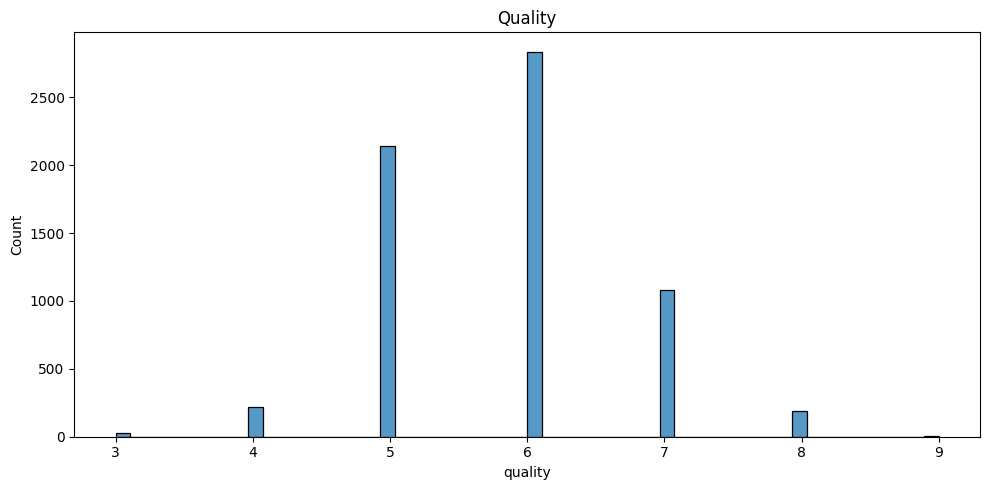

In [12]:
# Plot histogram for label
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=df, x='quality', ax=ax)
plt.title('Quality')
plt.tight_layout()
plt.show()

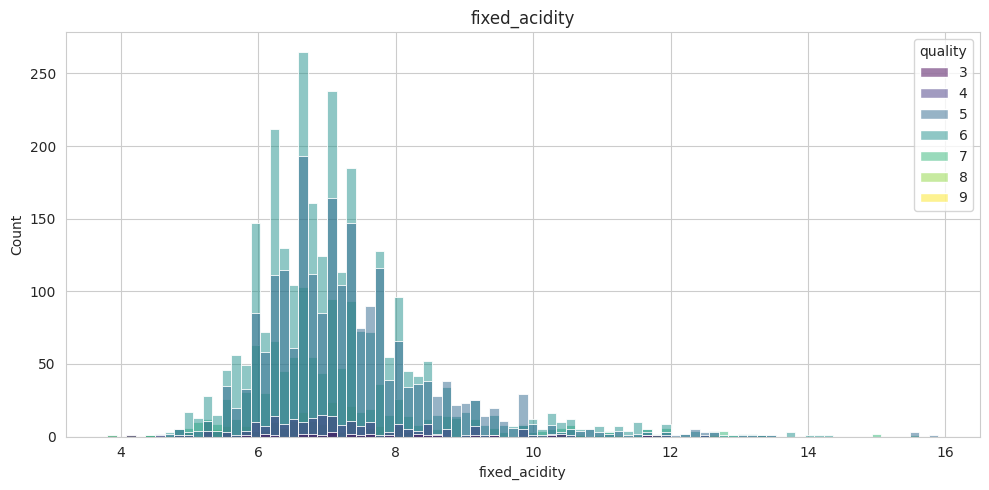

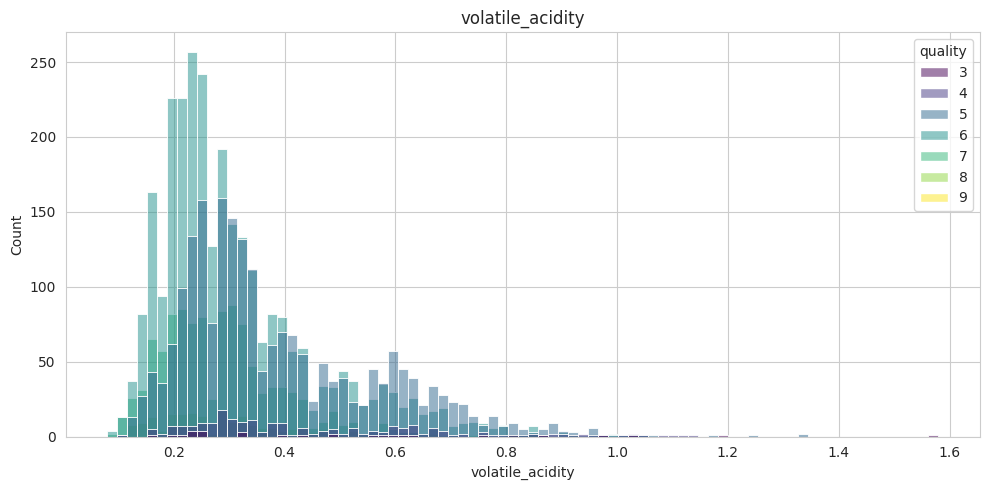

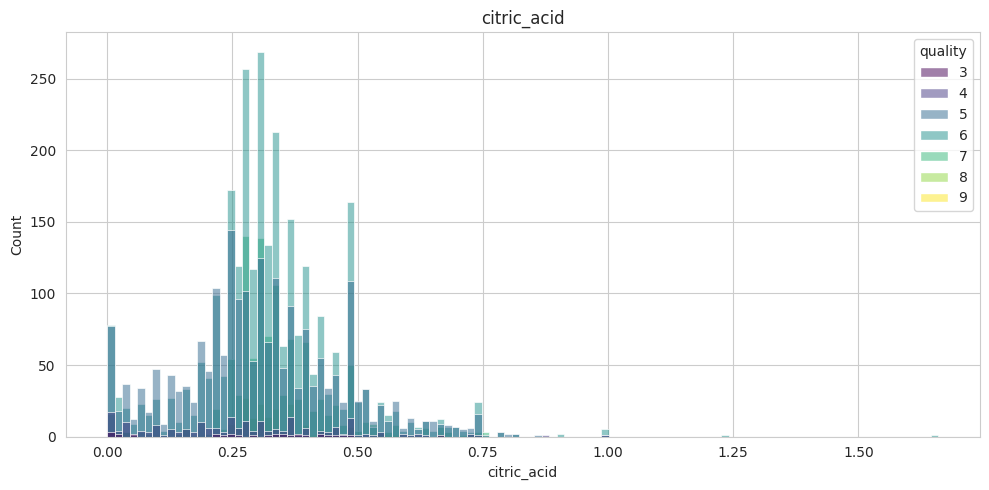

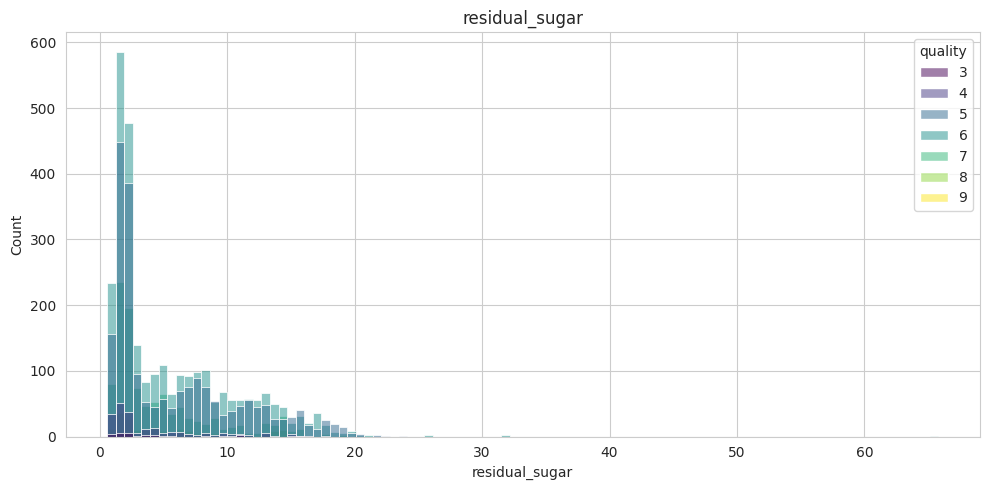

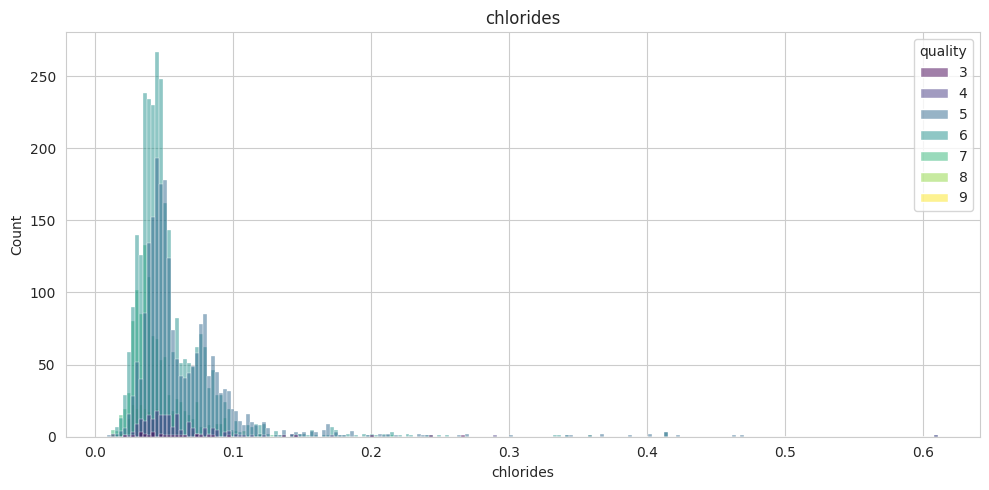

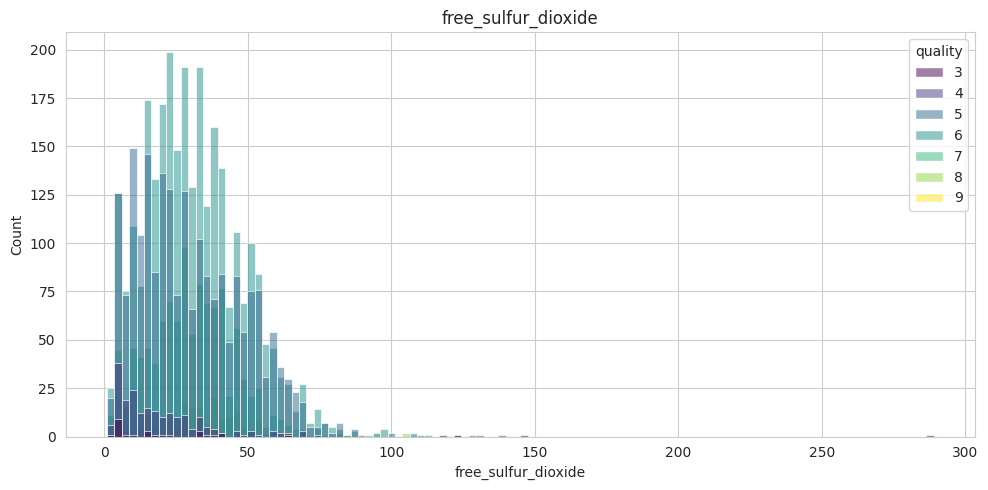

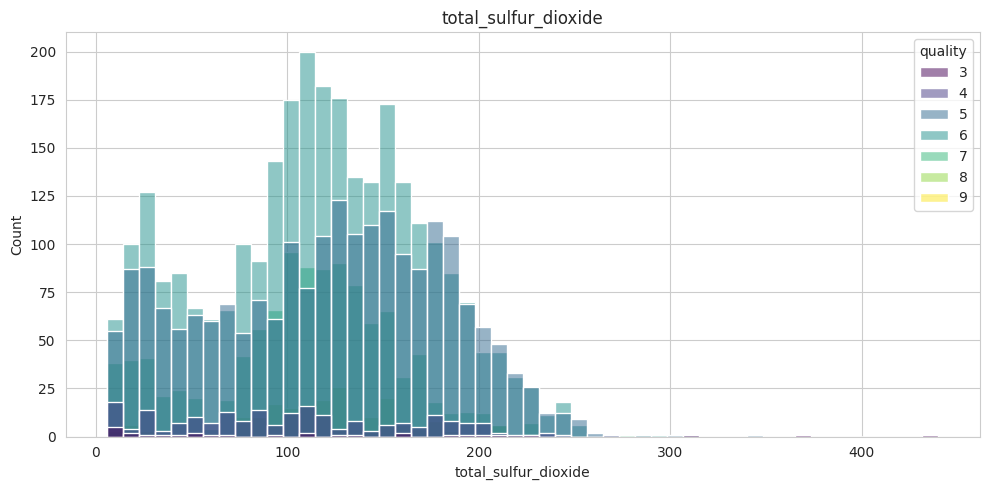

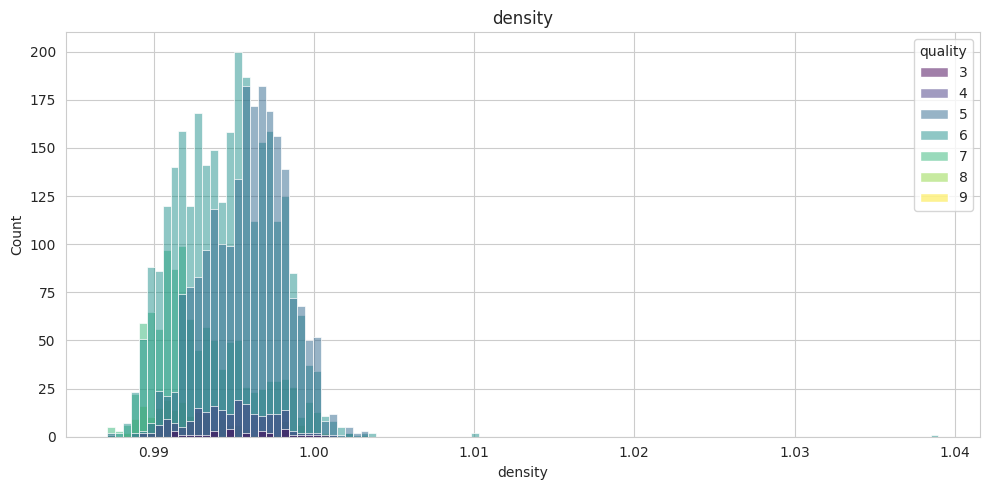

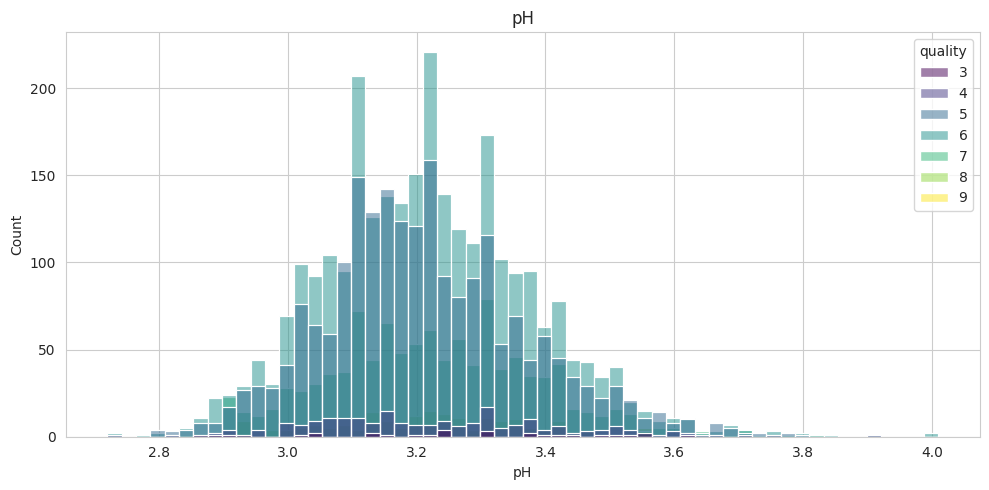

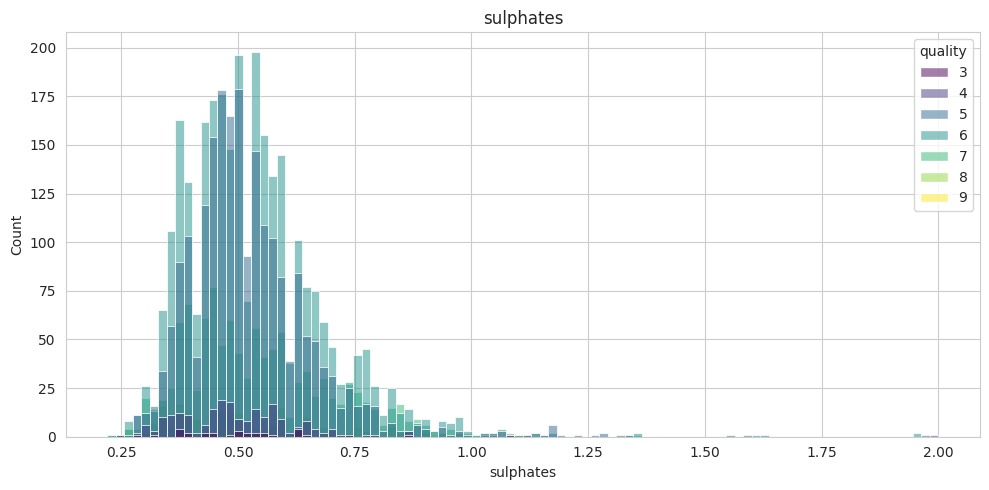

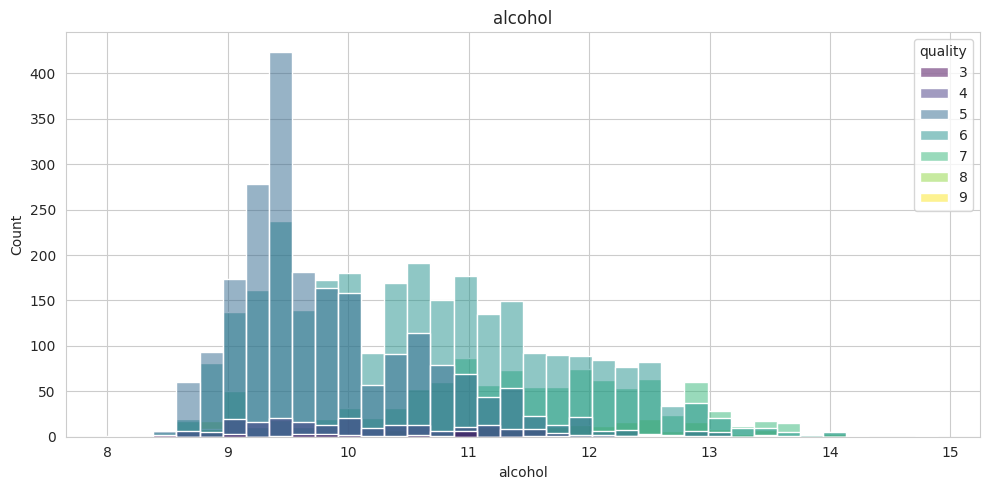

In [13]:
# Plot histogram for each feature
sns.set_style("whitegrid")

for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.histplot(data=df, x=col, hue='quality', palette='viridis', ax=ax)
    plt.title(col)
    plt.tight_layout()
    plt.show()

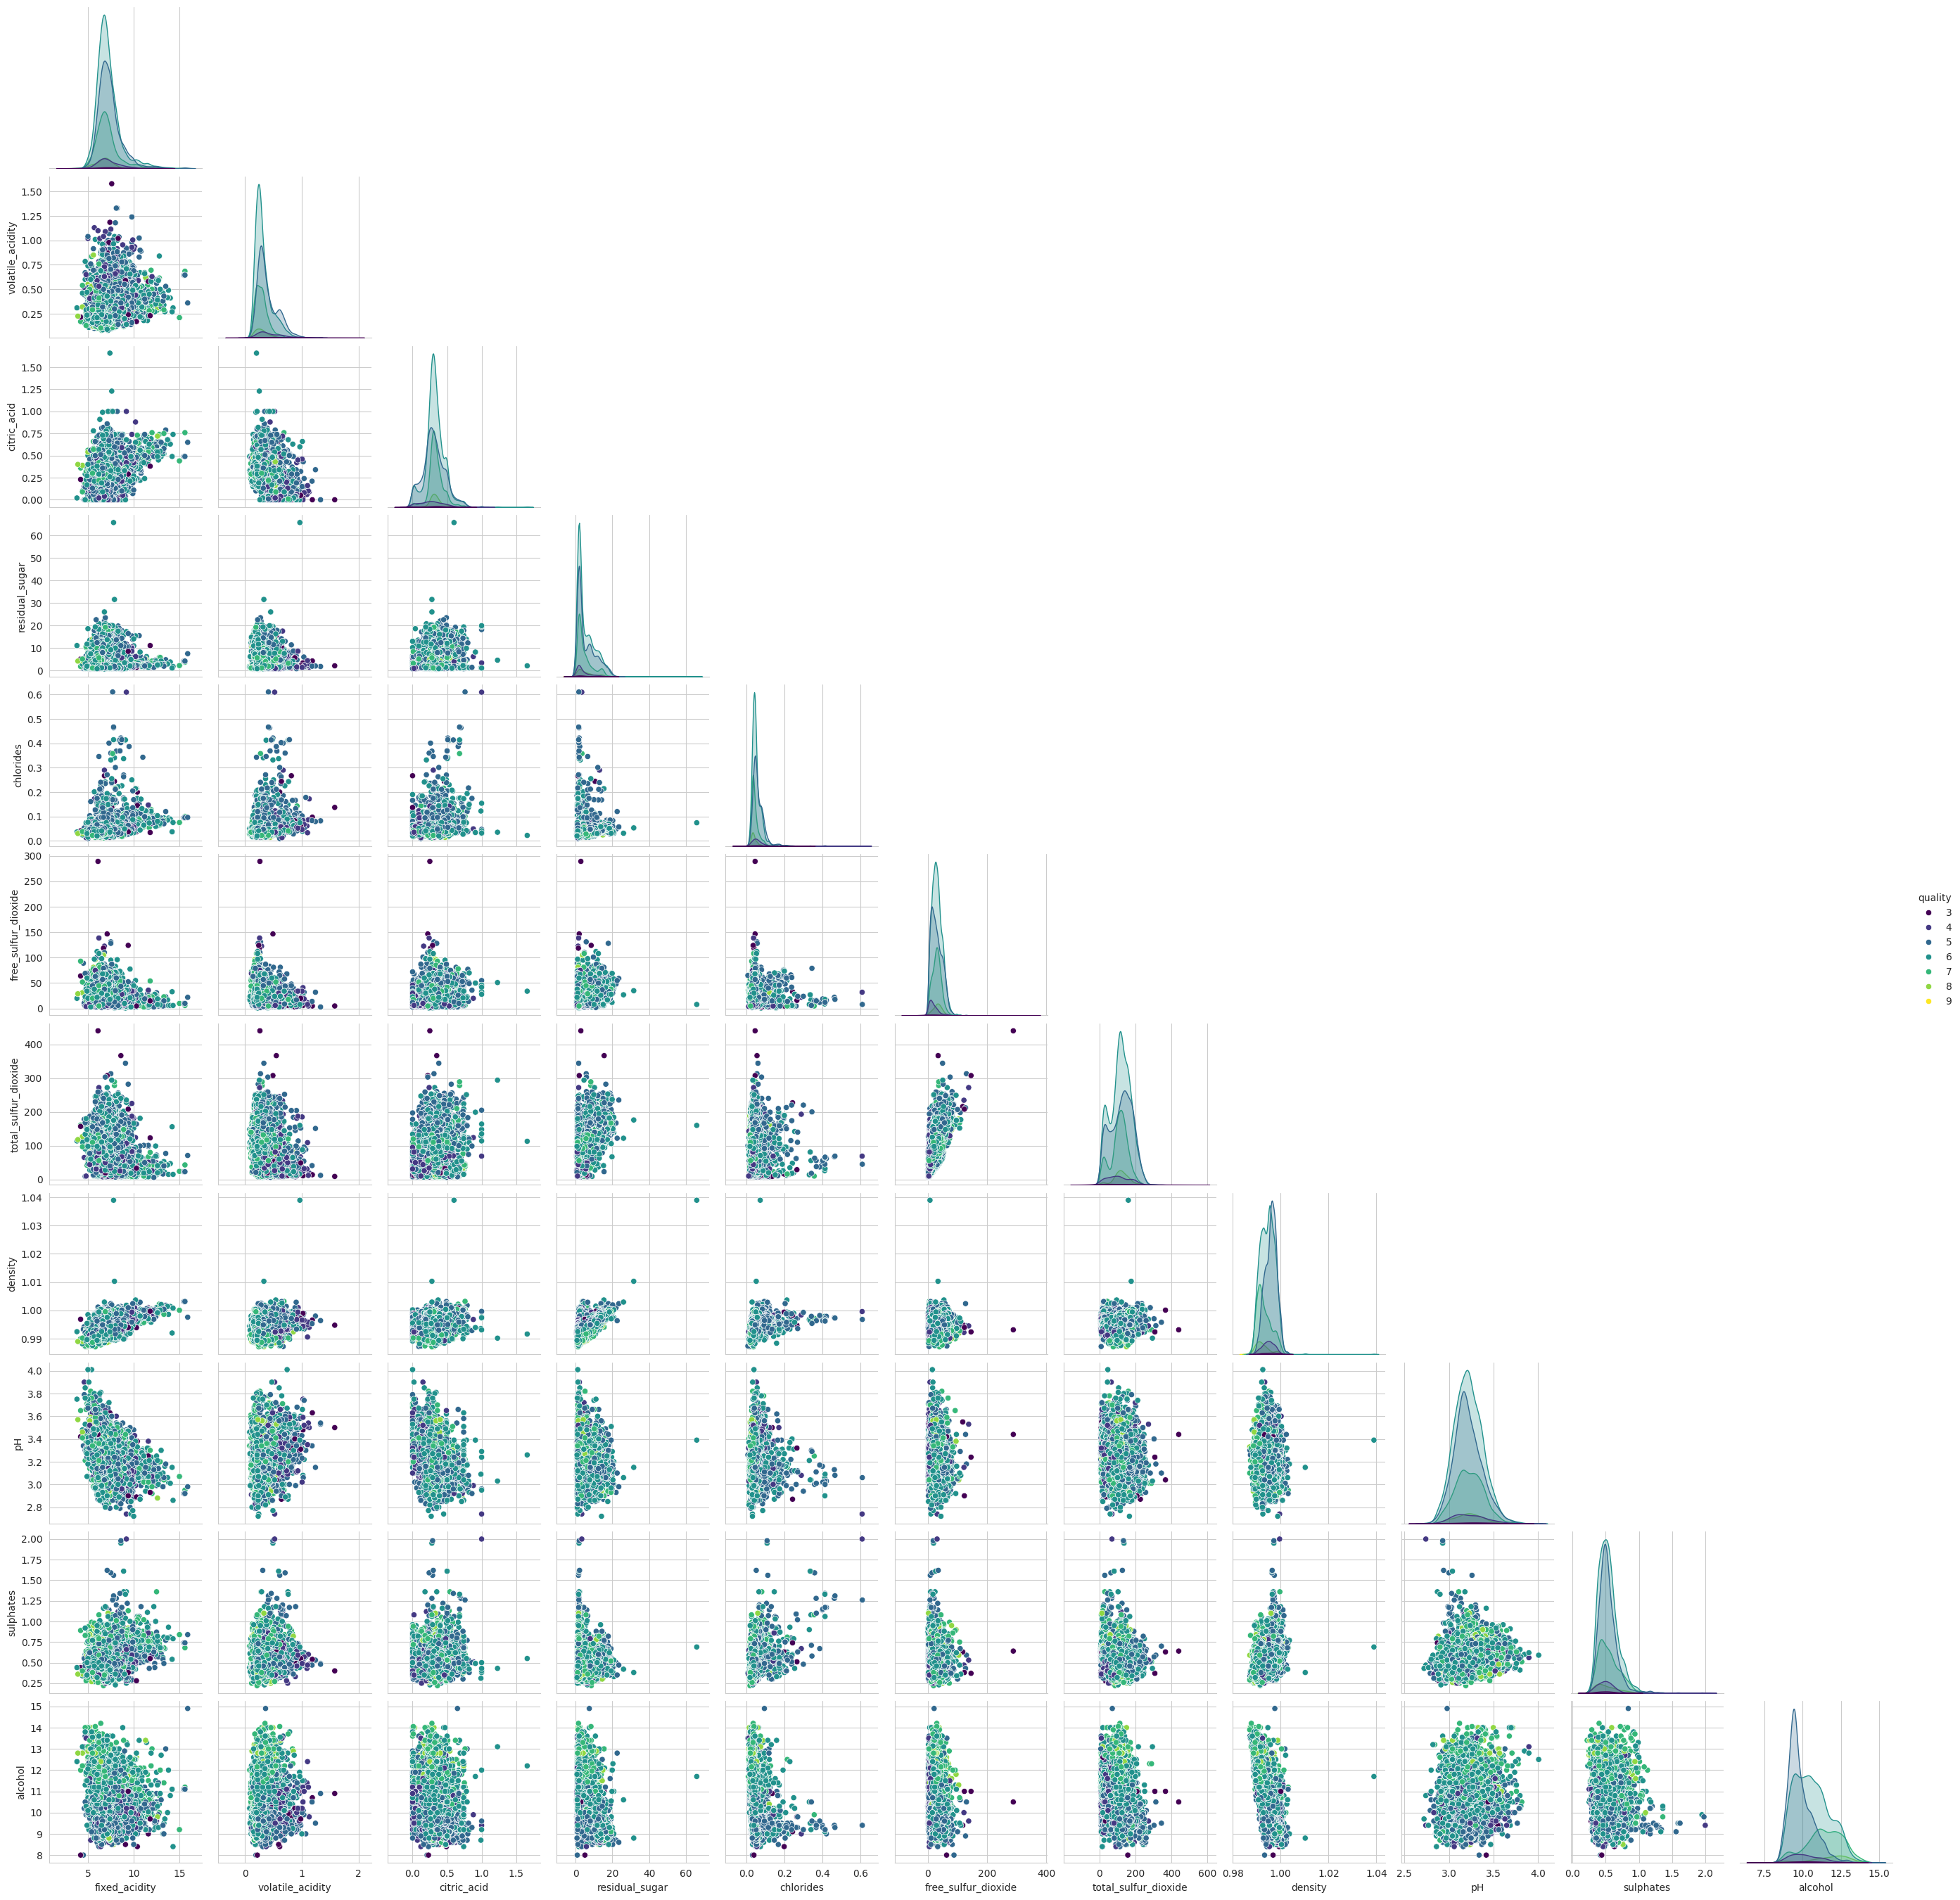

In [14]:
# Plot the pairplot
sns.pairplot(data=df, hue='quality', palette='viridis', corner=True)
plt.show()

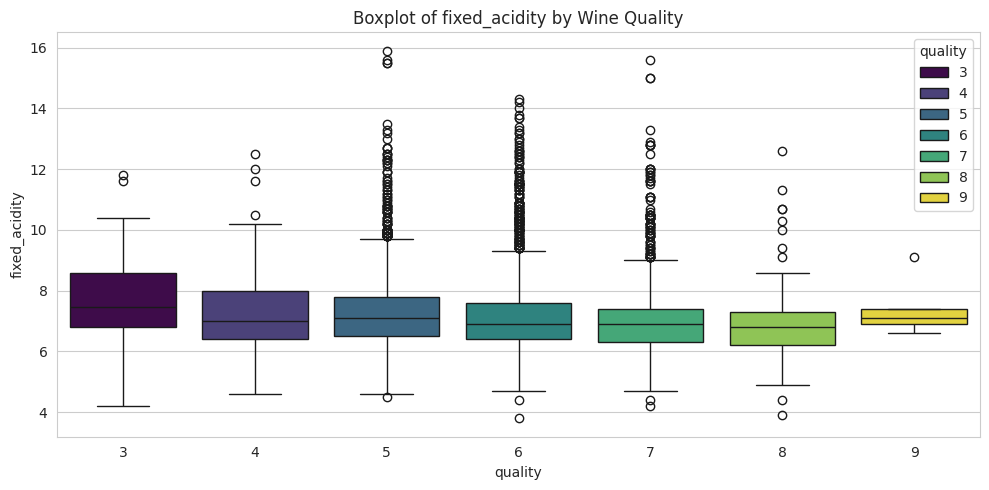

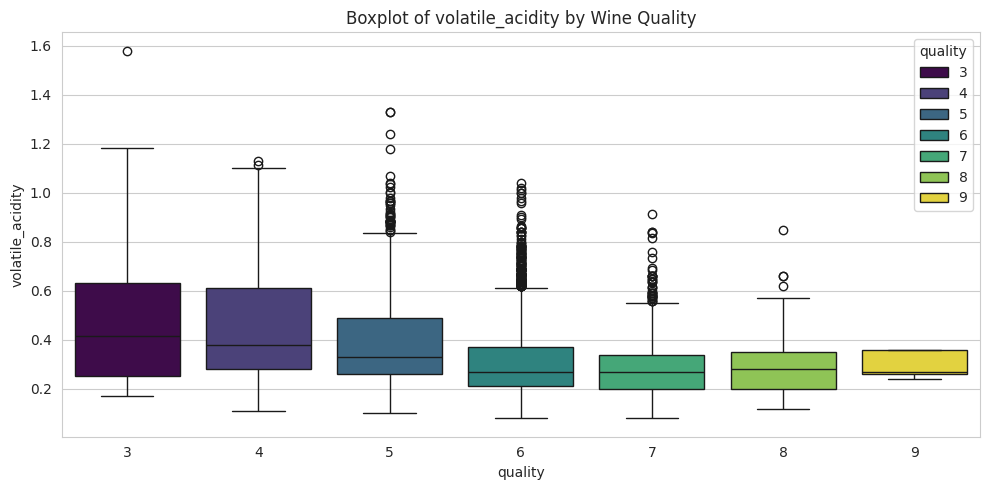

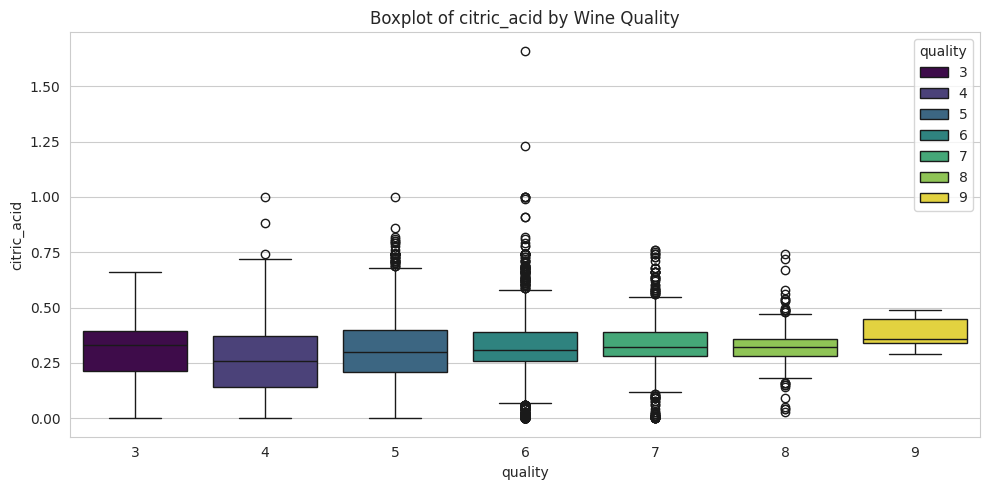

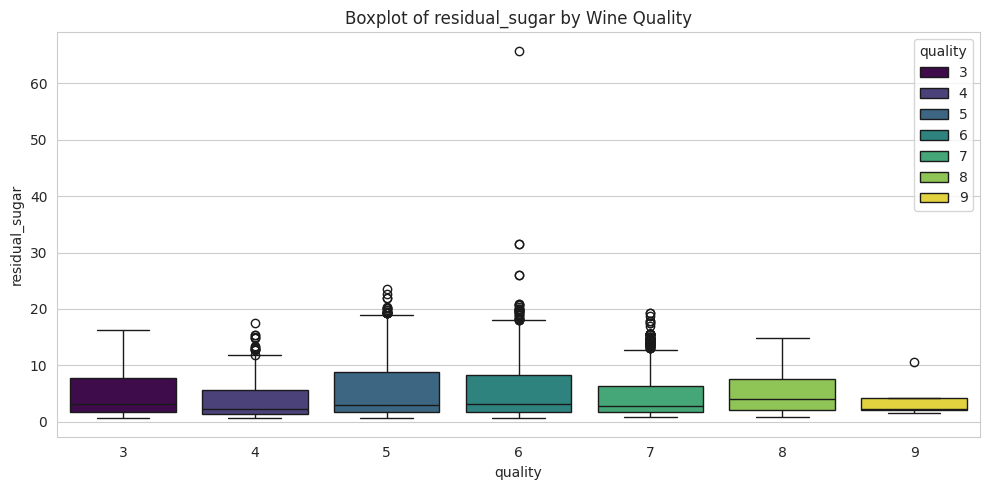

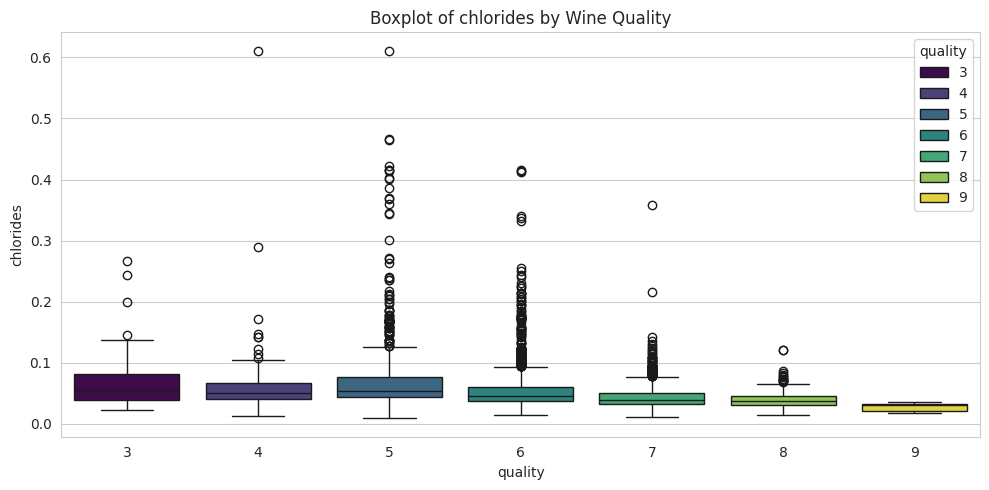

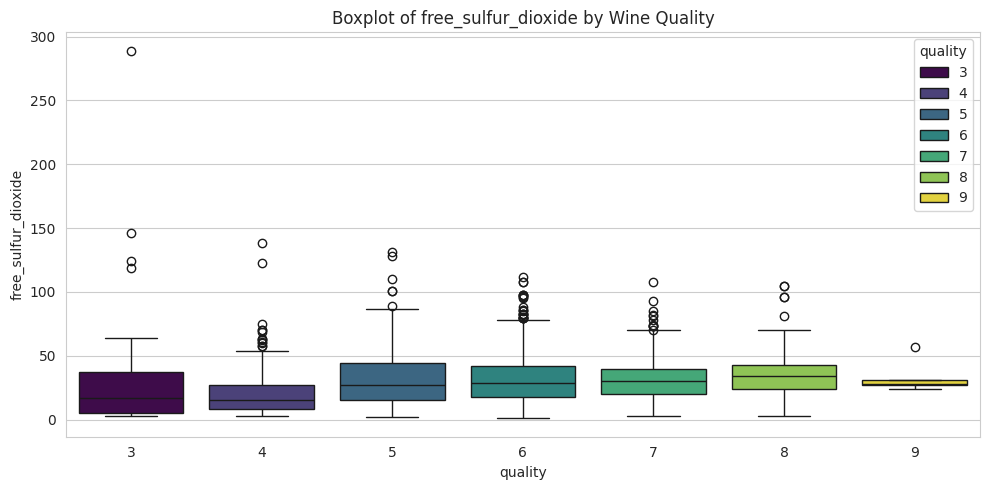

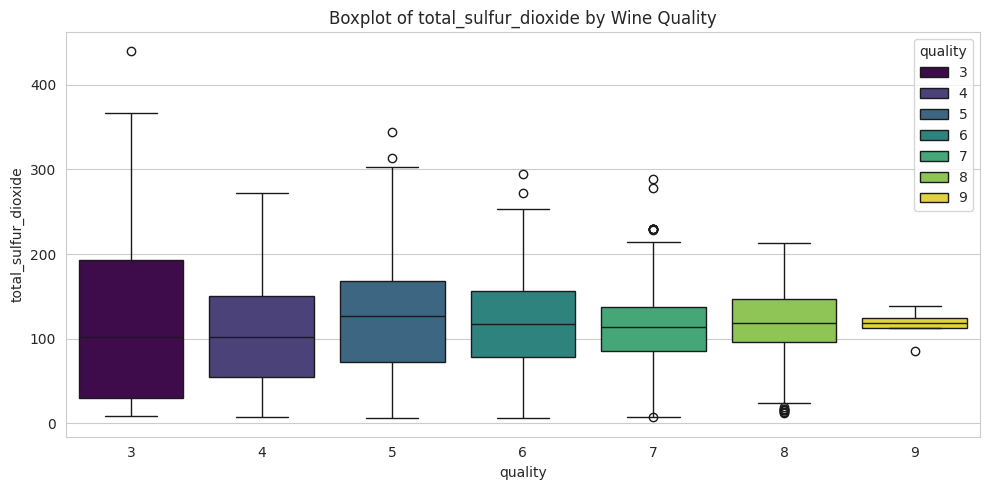

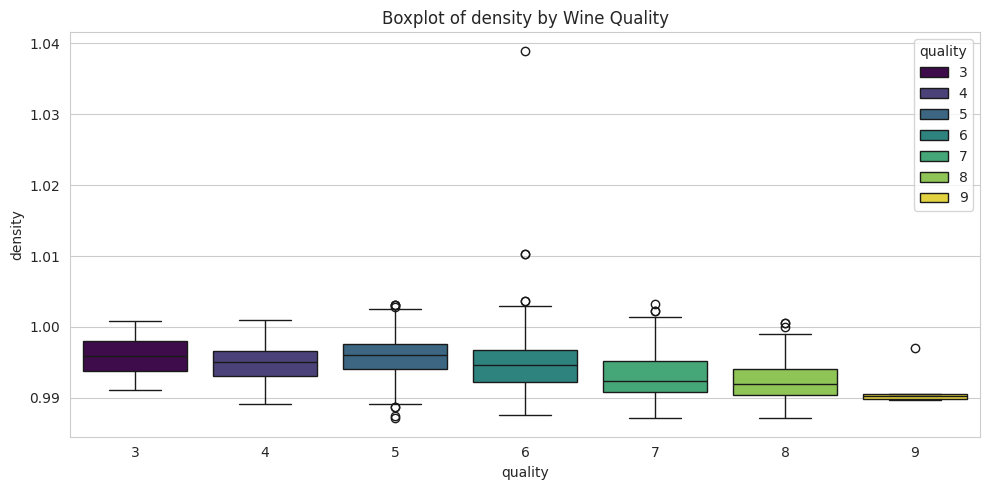

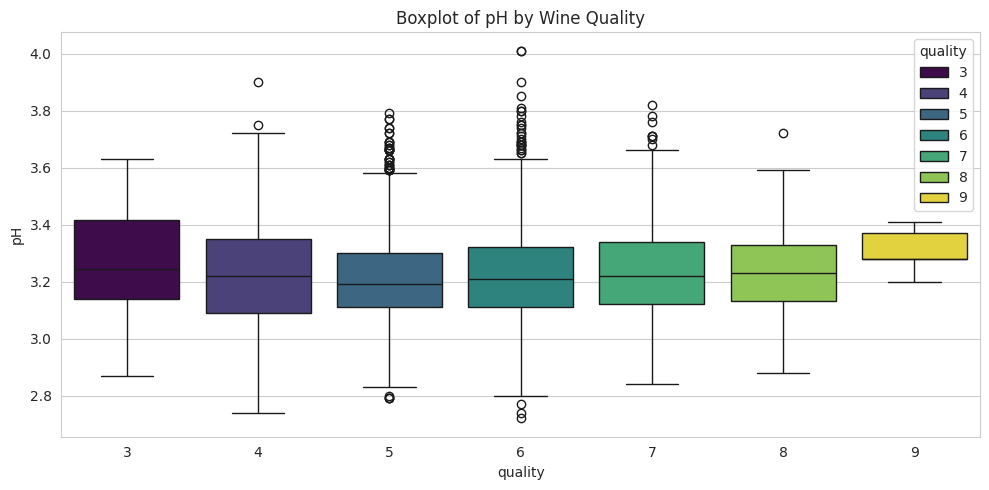

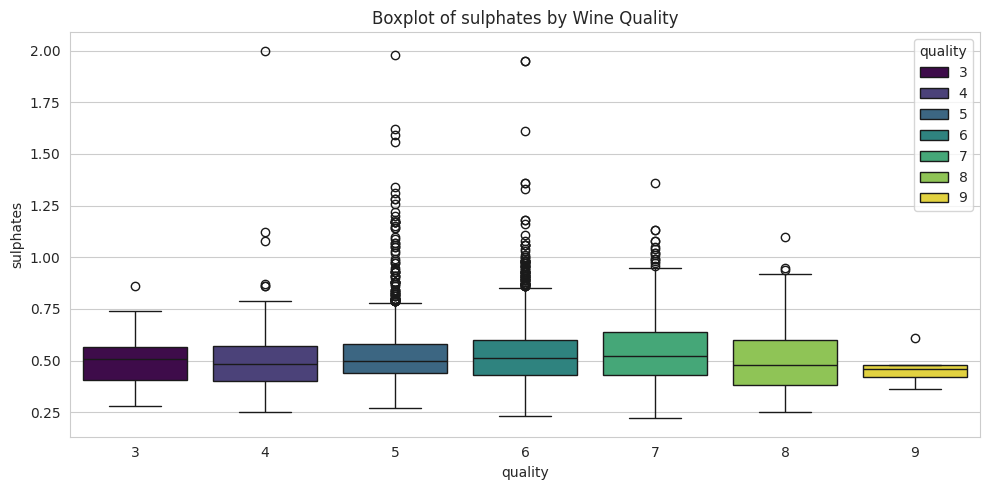

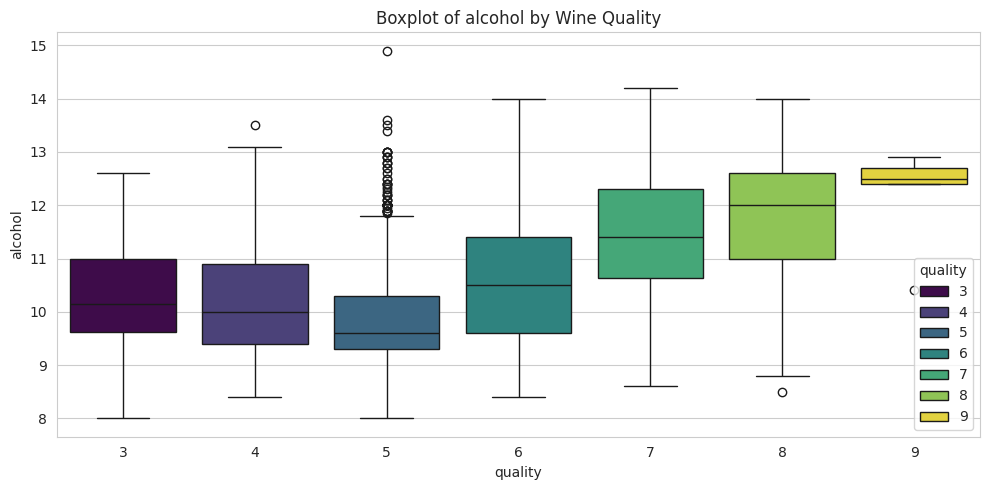

In [15]:
# Plot boxplot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.boxplot(data=df, x='quality', y=col, hue='quality', palette='viridis', ax=ax)
    plt.title(f'Boxplot of {col} by Wine Quality')
    plt.tight_layout()
    plt.show()

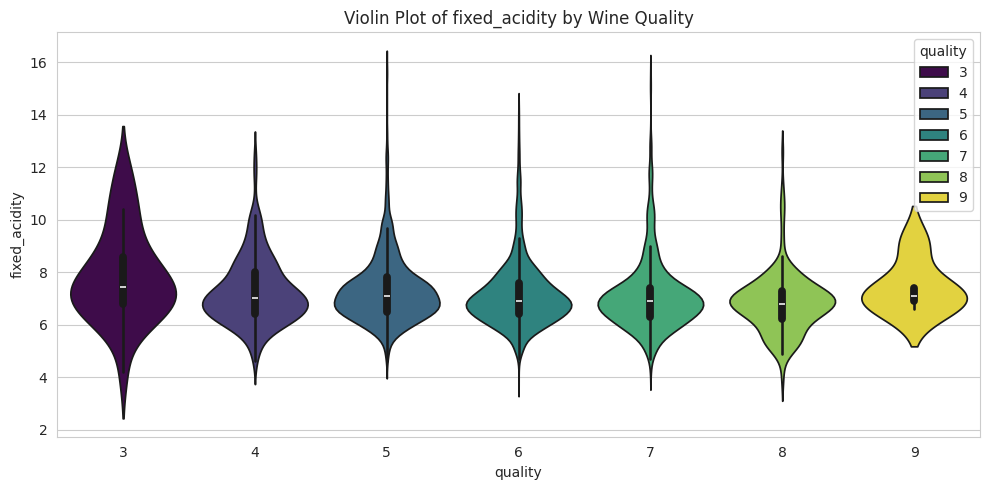

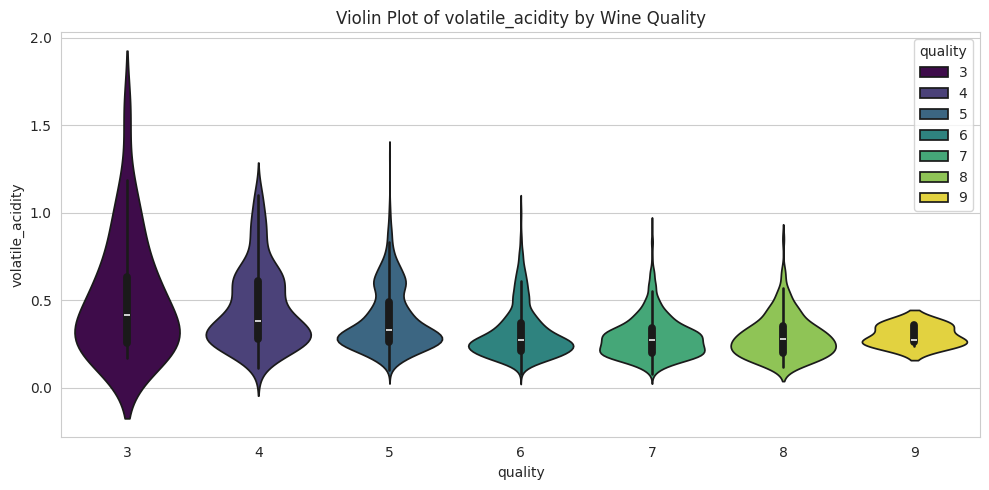

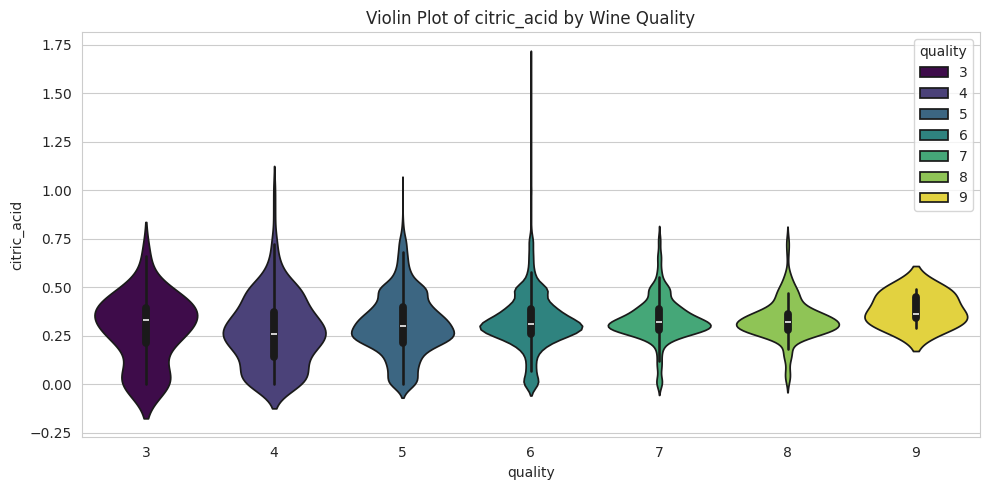

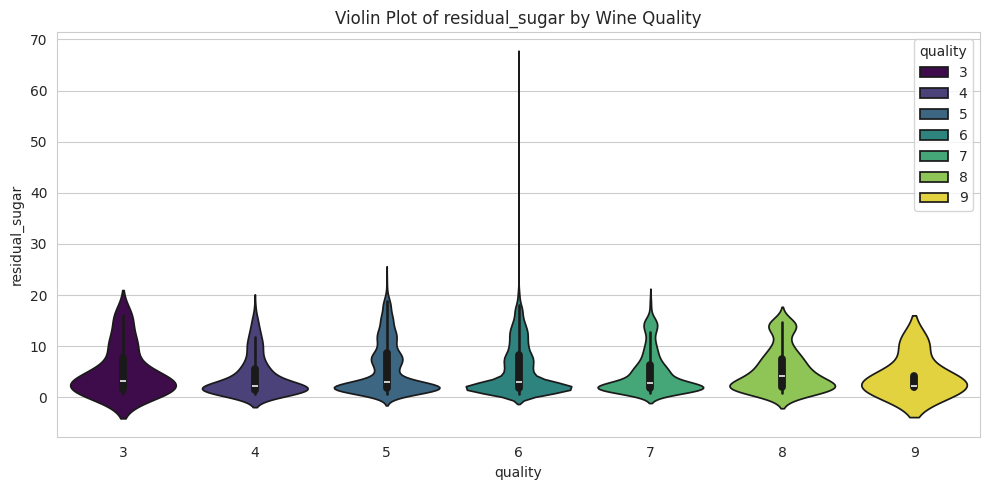

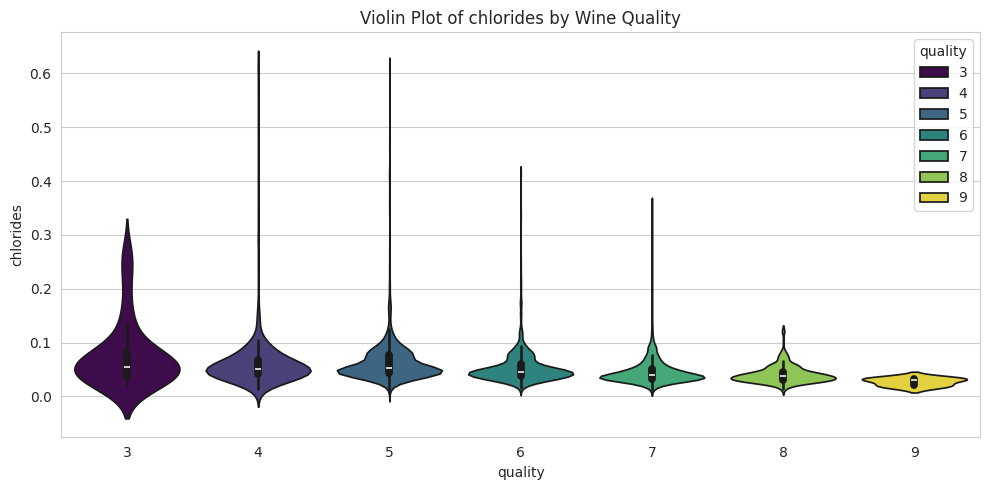

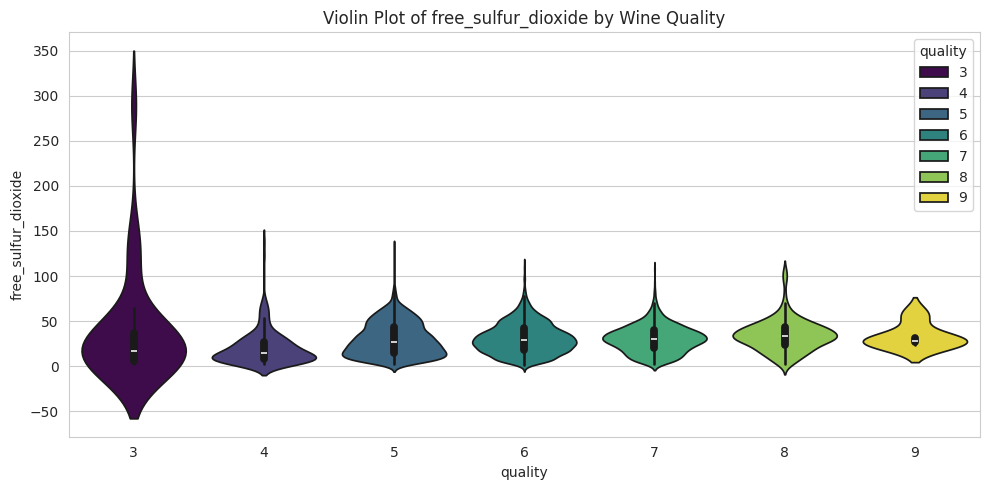

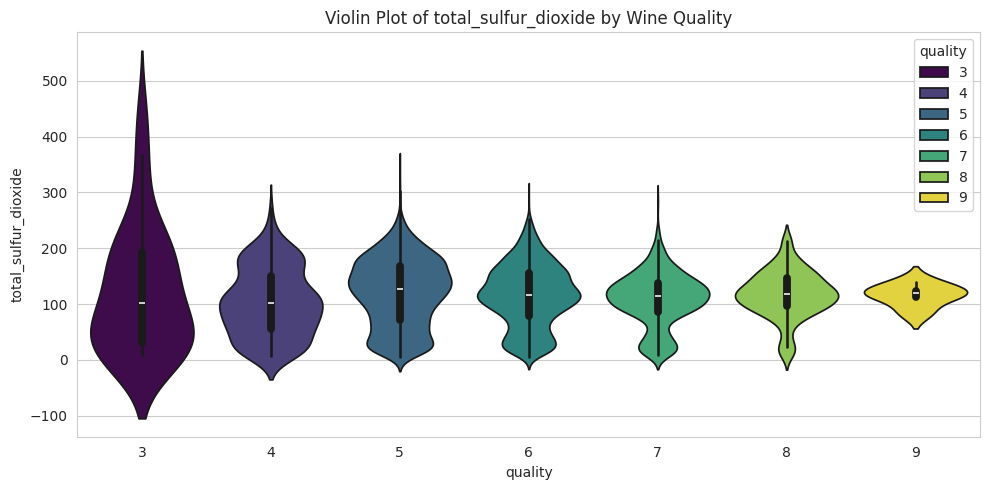

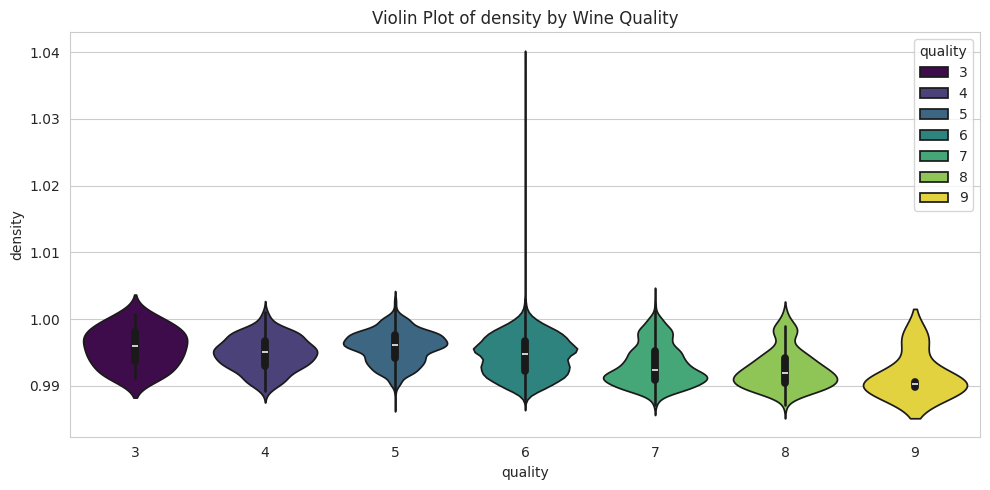

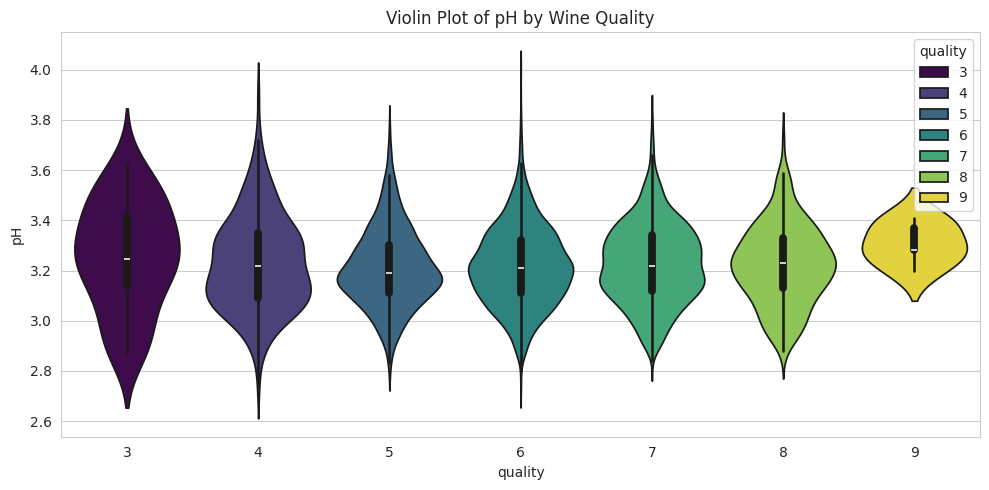

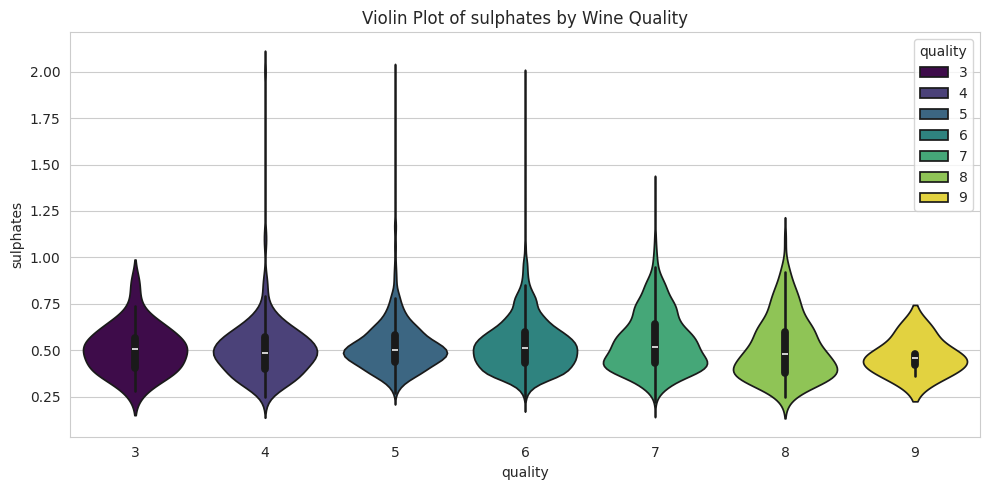

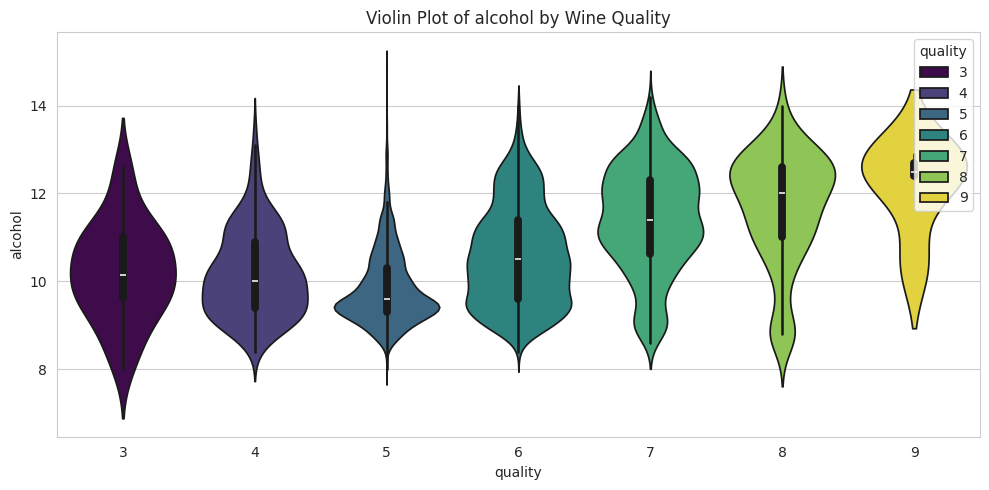

In [16]:
# Plot violin plot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 5))
    sns.violinplot(data=df, x='quality', y=col, hue='quality', palette='viridis', ax=ax)
    plt.title(f'Violin Plot of {col} by Wine Quality')
    plt.tight_layout()
    plt.show()

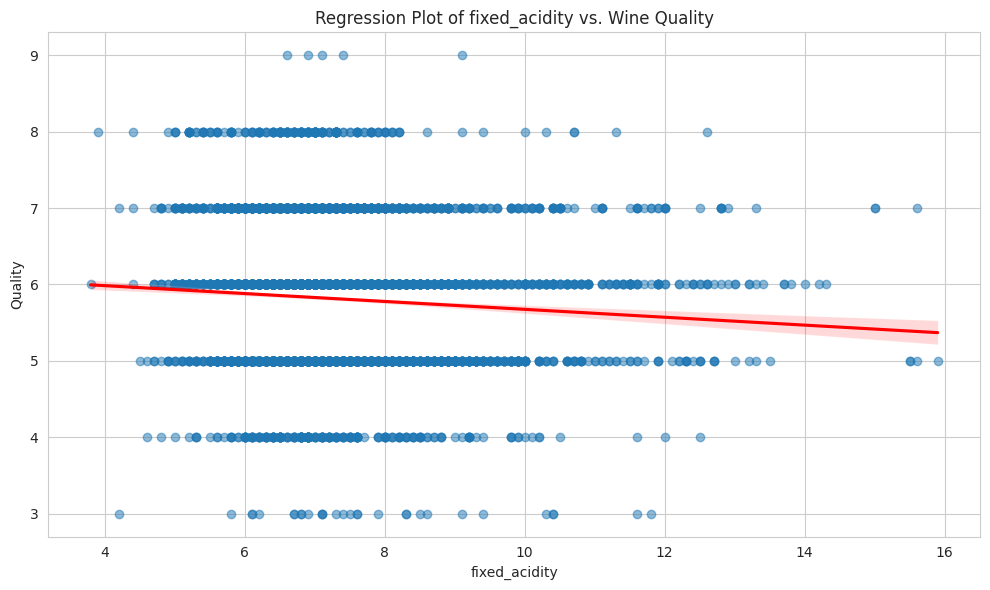

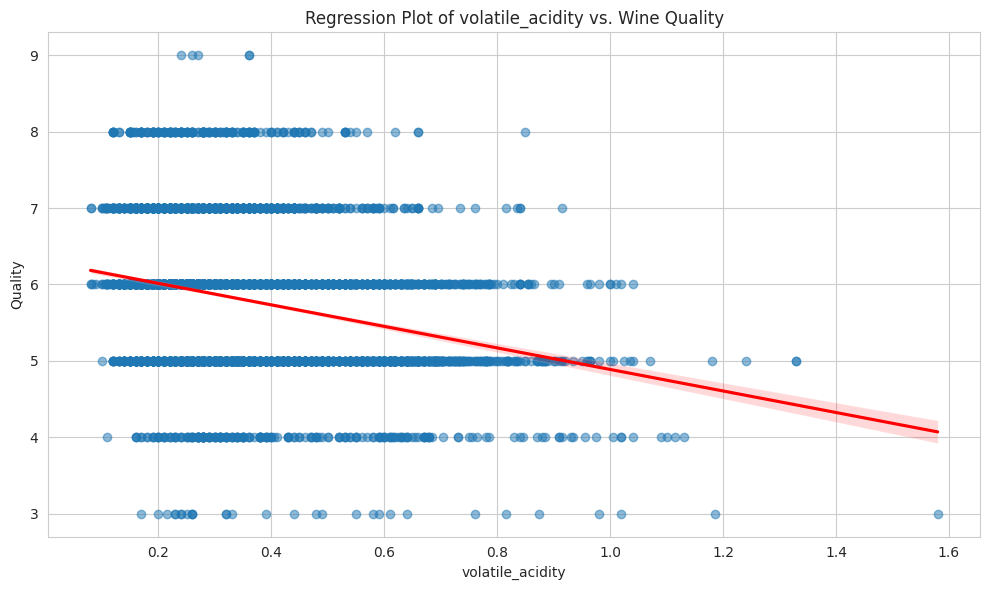

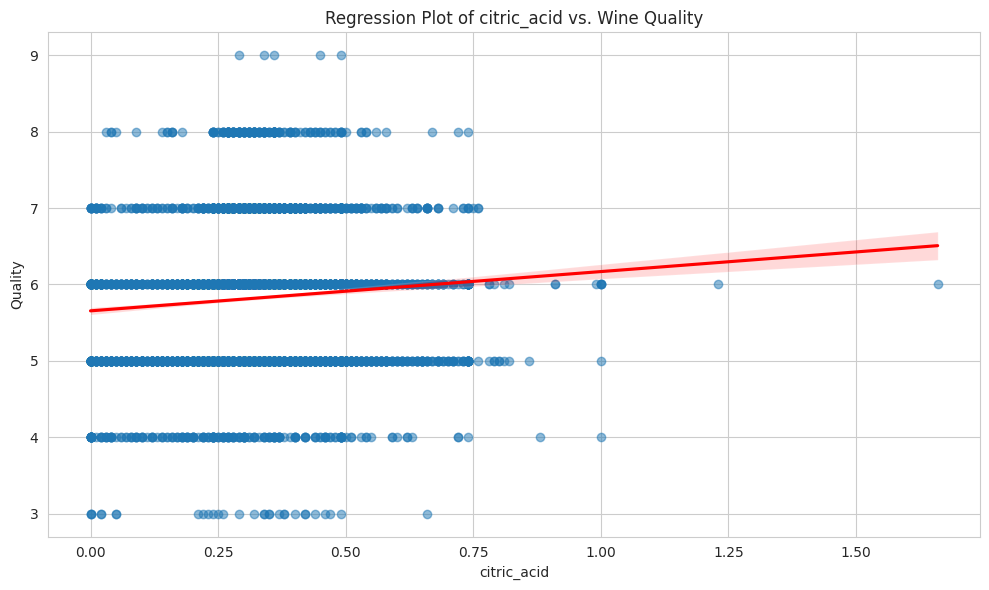

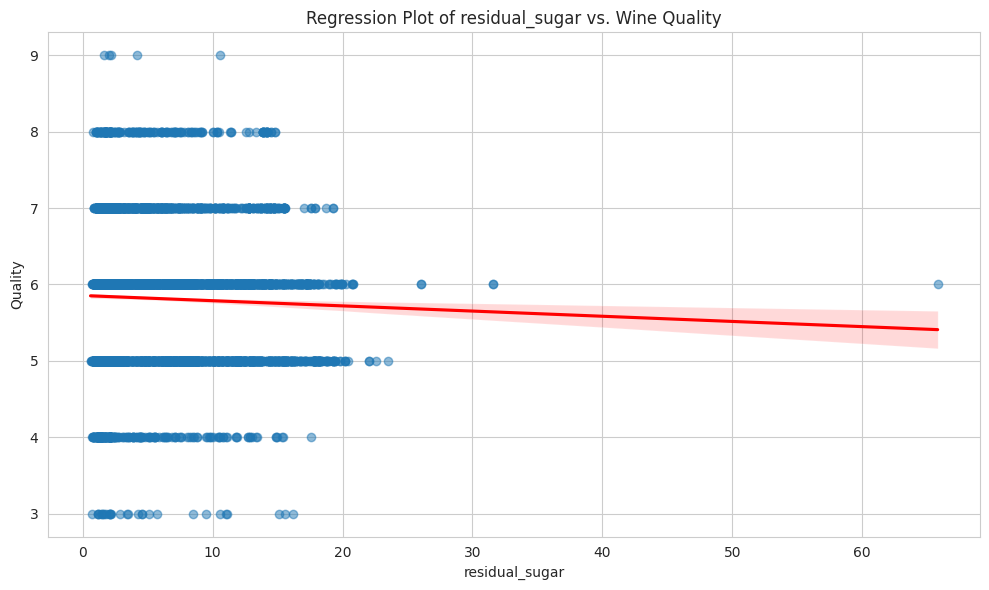

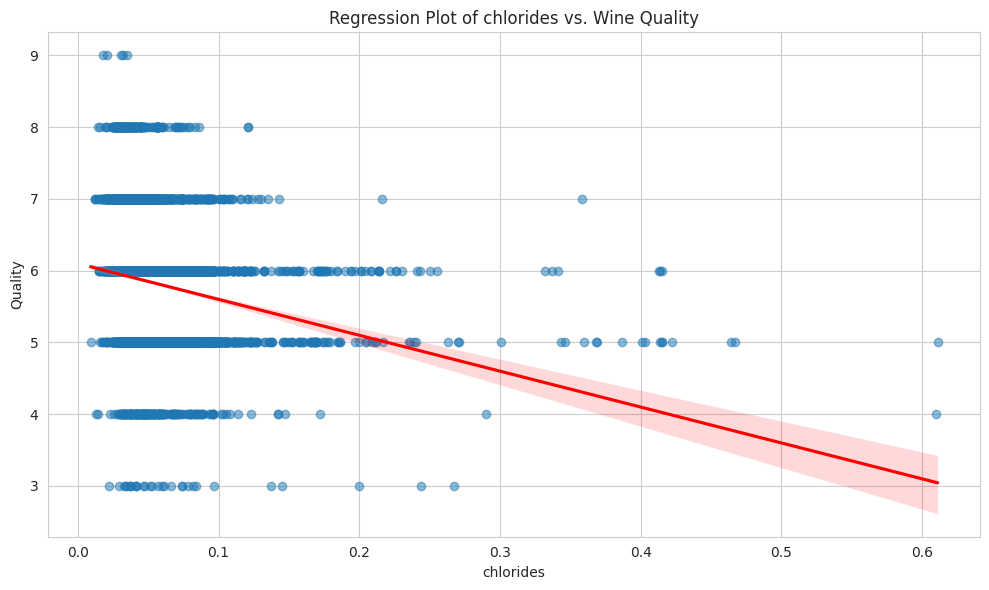

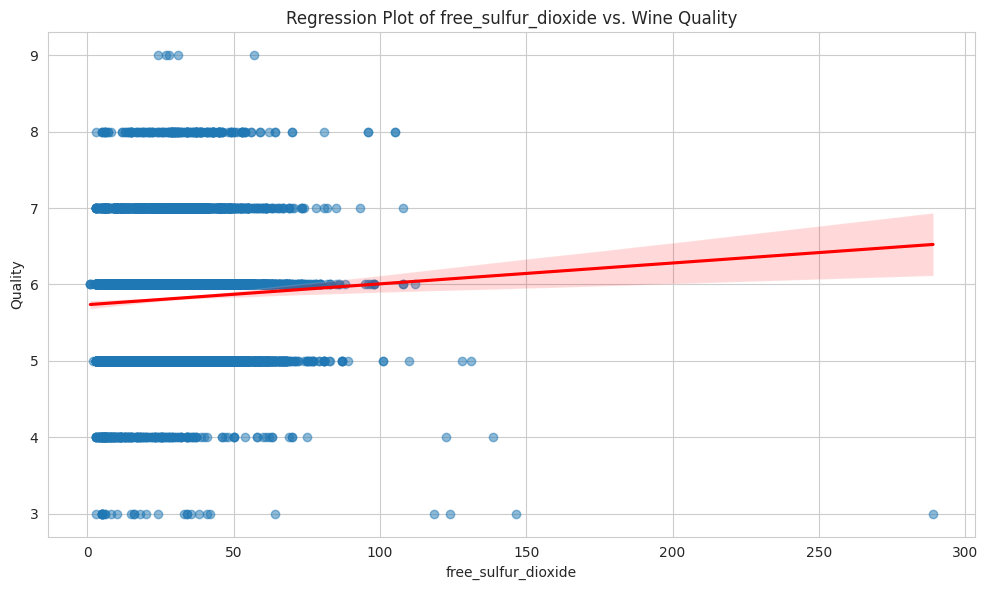

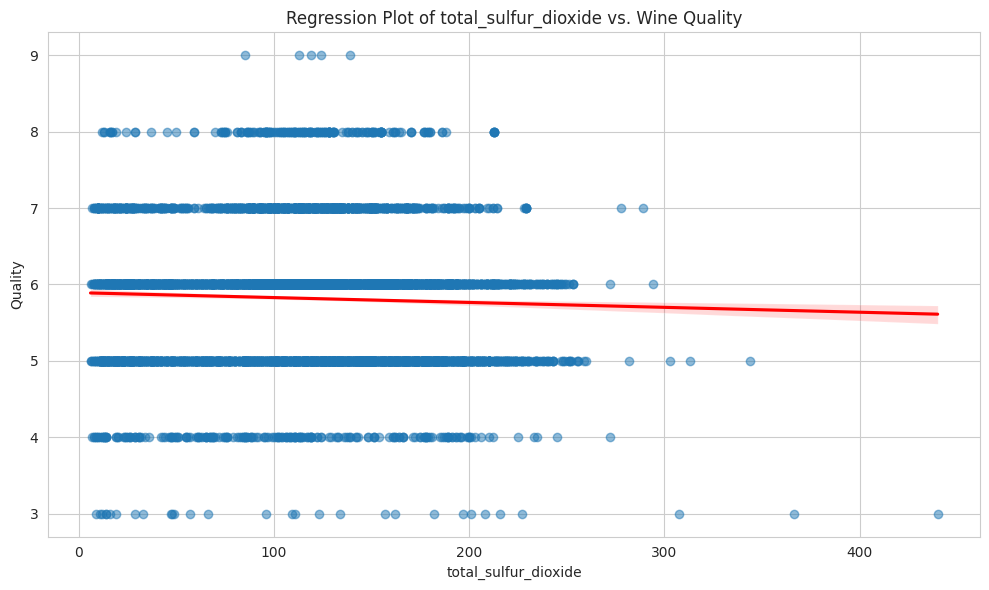

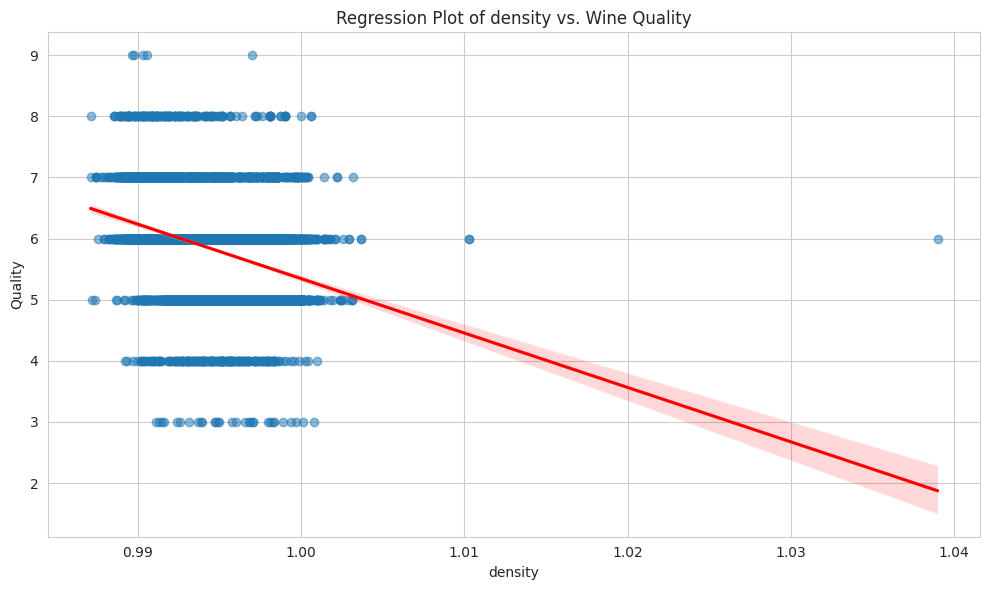

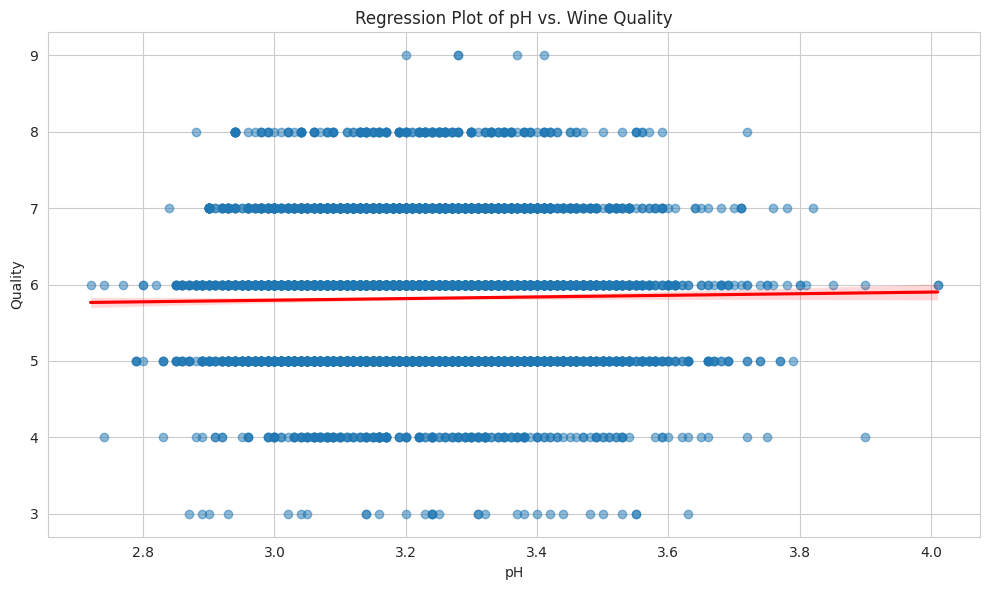

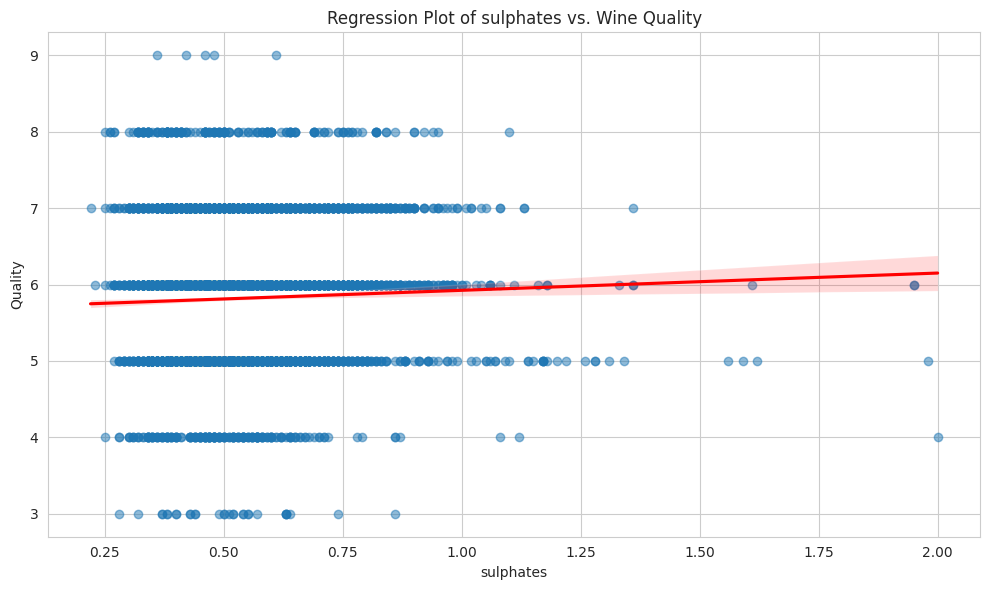

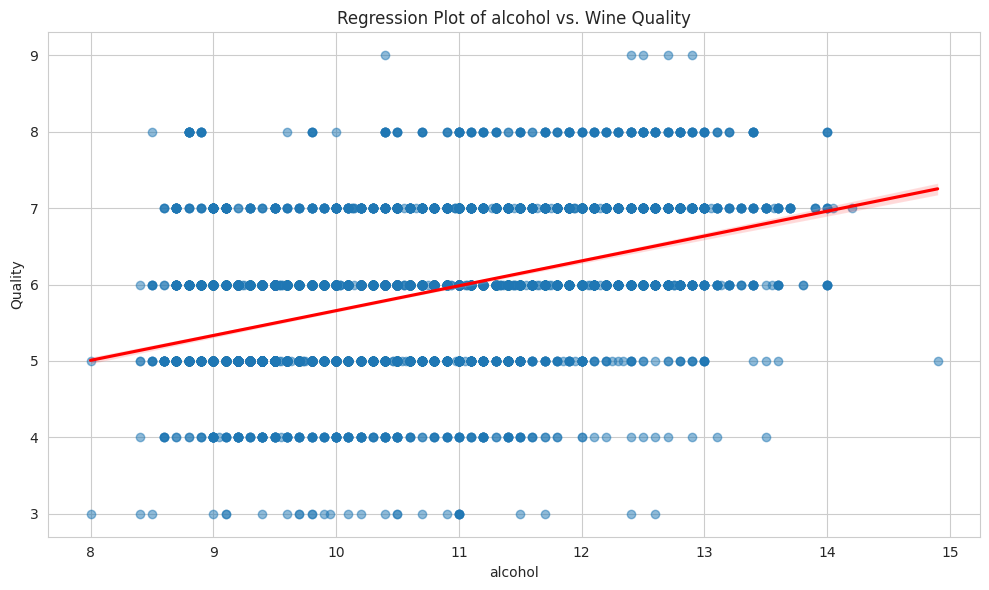

In [17]:
# Plot regplot for each feature
for col in [col for col in df.columns if col != 'quality']:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.regplot(data=df, x=col, y='quality', ax=ax, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
    plt.title(f'Regression Plot of {col} vs. Wine Quality')
    plt.xlabel(col)
    plt.ylabel('Quality')
    plt.tight_layout()
    plt.show()

In [18]:
# Create correlation matrix
corr = df.corr().round(2)
corr

fixed_acidity  volatile_acidity  citric_acid  \
fixed_acidity                  1.00              0.22         0.32   
volatile_acidity               0.22              1.00        -0.38   
citric_acid                    0.32             -0.38         1.00   
residual_sugar                -0.11             -0.20         0.14   
chlorides                      0.30              0.38         0.04   
free_sulfur_dioxide           -0.28             -0.35         0.13   
total_sulfur_dioxide          -0.33             -0.41         0.20   
density                        0.46              0.27         0.10   
pH                            -0.25              0.26        -0.33   
sulphates                      0.30              0.23         0.06   
alcohol                       -0.10             -0.04        -0.01   
quality                       -0.08             -0.27         0.09   

                      residual_sugar  chlorides  free_sulfur_dioxide  \
fixed_acidity                  -0.11       0.30                -0.28   
volatile_acidity               -0.20       0.38                -0.35   
citric_acid                     0.14       0.04                 0.13   
residual_sugar                  1.00      -0.13                 0.40   
chlorides                      -0.13       1.00                -0.20   
free_sulfur_dioxide             0.40      -0.20                 1.00   
total_sulfur_dioxide            0.50      -0.28                 0.72   
density                         0.55       0.36                 0.03   
pH                             -0.27       0.04                -0.15   
sulphates                      -0.19       0.40                -0.19   
alcohol                        -0.36      -0.26                -0.18   
quality                        -0.04      -0.20                 0.06   

                      total_sulfur_dioxide  density    pH  sulphates  alcohol  \
fixed_acidity                        -0.33     0.46 -0.25       0.30    -0.10   
volatile_acidity                     -0.41     0.27  0.26       0.23    -0.04   
citric_acid                           0.20     0.10 -0.33       0.06    -0.01   
residual_sugar                        0.50     0.55 -0.27      -0.19    -0.36   
chlorides                            -0.28     0.36  0.04       0.40    -0.26   
free_sulfur_dioxide                   0.72     0.03 -0.15      -0.19    -0.18   
total_sulfur_dioxide                  1.00     0.03 -0.24      -0.28    -0.27   
density                               0.03     1.00  0.01       0.26    -0.69   
pH                                   -0.24     0.01  1.00       0.19     0.12   
sulphates                            -0.28     0.26  0.19       1.00    -0.00   
alcohol                              -0.27    -0.69  0.12      -0.00     1.00   
quality                              -0.04    -0.31  0.02       0.04     0.44   

                      quality  
fixed_acidity           -0.08  
volatile_acidity        -0.27  
citric_acid              0.09  
residual_sugar          -0.04  
chlorides               -0.20  
free_sulfur_dioxide      0.06  
total_sulfur_dioxide    -0.04  
density                 -0.31  
pH                       0.02  
sulphates                0.04  
alcohol                  0.44  
quality                  1.00

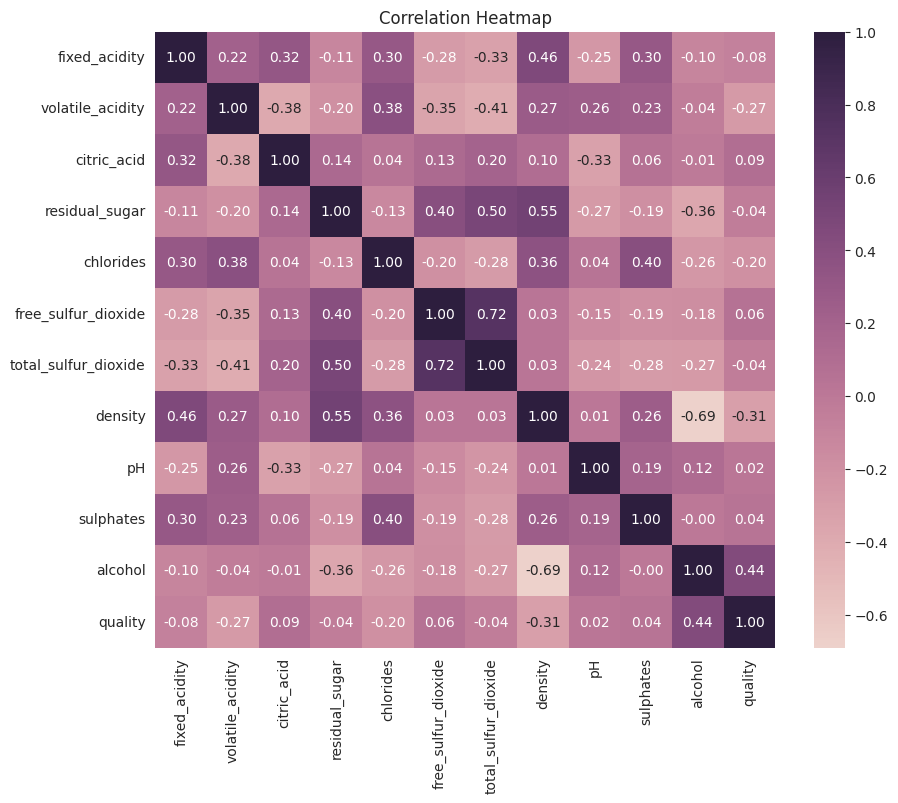

In [19]:
# Create correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap=sns.cubehelix_palette(as_cmap=True), cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Preparing the Data

## Partitioning the Data

In [20]:
# Split the data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [21]:
# Print the shapes
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}\n")

print(f"X_val: {X_val.shape}")
print(f"y_val: {y_val.shape}\n")

print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

X_train: (3898, 11)
y_train: (3898, 1)

X_val: (1299, 11)
y_val: (1299, 1)

X_test: (1300, 11)
y_test: (1300, 1)


In [22]:
# Examine training set
X_train.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3778            7.7              0.24         0.31             1.3      0.047   
4825            5.7              0.20         0.30             2.5      0.046   
5805            5.9              0.32         0.20            14.4      0.050   
2227            7.0              0.32         0.24             6.2      0.048   
3266            8.8              0.39         0.34             5.9      0.055   

      free_sulfur_dioxide  total_sulfur_dioxide  density    pH  sulphates  \
3778                 33.0                 106.0  0.99300  3.22       0.55   
4825                 38.0                 125.0  0.99276  3.34       0.50   
5805                 29.0                 144.0  0.99666  3.24       0.41   
2227                 31.0                 228.0  0.99570  3.23       0.62   
3266                 33.0                 128.0  0.99270  2.95       0.51   

      alcohol  
3778     10.8  
4825      9.9  
5805     10.3  
2227      9.4  
3266     11.8

## Standardizing the Data

In [23]:
# Standardize the sets
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [24]:
# Examine the DataFrame
X_train.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3778       0.348584         -0.605040    -0.071464       -0.864150  -0.265163   
4825      -1.195178         -0.846230    -0.140518       -0.616474  -0.293311   
5805      -1.040802         -0.122660    -0.831063        1.839648  -0.180718   
2227      -0.191733         -0.122660    -0.554845        0.147194  -0.237014   
3266       1.197653          0.299422     0.135700        0.085275  -0.039977   

      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
3778             0.145703             -0.168381 -0.587838  0.014263   
4825             0.435859              0.166640 -0.666817  0.773261   
5805            -0.086421              0.501661  0.616595  0.140763   
2227             0.029641              1.982807  0.300678  0.077513   
3266             0.145703              0.219538 -0.686562 -1.693484   

      sulphates   alcohol  
3778   0.124593  0.284094  
4825  -0.220094 -0.477681  
5805  -0.840532 -0.139114  
2227   0.607156 -0.900890  
3266  -0.151157  1.130511

## Array Conversion

In [25]:
# Convert labels to arrays
y_train_np = y_train.values.ravel()
y_val_np = y_val.values.ravel()
y_test_np = y_test.values.ravel()

In [26]:
# Examine the shape
print(f"Shape of y_train_np: {y_train_np.shape}")

Shape of y_train_np: (3898,)


## PT Tabular Datasets

In [27]:
# Create PyTorch Tabular datasets
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_val, y_val], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

In [28]:
# Examine the DataFrame
train_df.head()

fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
3778       0.348584         -0.605040    -0.071464       -0.864150  -0.265163   
4825      -1.195178         -0.846230    -0.140518       -0.616474  -0.293311   
5805      -1.040802         -0.122660    -0.831063        1.839648  -0.180718   
2227      -0.191733         -0.122660    -0.554845        0.147194  -0.237014   
3266       1.197653          0.299422     0.135700        0.085275  -0.039977   

      free_sulfur_dioxide  total_sulfur_dioxide   density        pH  \
3778             0.145703             -0.168381 -0.587838  0.014263   
4825             0.435859              0.166640 -0.666817  0.773261   
5805            -0.086421              0.501661  0.616595  0.140763   
2227             0.029641              1.982807  0.300678  0.077513   
3266             0.145703              0.219538 -0.686562 -1.693484   

      sulphates   alcohol  quality  
3778   0.124593  0.284094        6  
4825  -0.220094 -0.477681        6  
5805  -0.840532 -0.139114        6  
2227   0.607156 -0.900890        6  
3266  -0.151157  1.130511        6

# Model Selection

In [29]:
# Class to train and evaluate a group of regression models
class UnifiedRegressor:
    def __init__(self, model_type, **kwargs):
        self.model_type = model_type.lower()
        self.kwargs = kwargs
        self.model = None
        self.is_pytorch_tabular = self.model_type in ['tabnet', 'tabtransformer', 'node', 'gandalf']
        if not self.is_pytorch_tabular:
            self._init_model()

    def _init_model(self):
        """Initializes traditional ML models based on the specified model type."""
        model_mapping = {
            'linear': LinearRegression,
            'svm': SVR,
            'randomforest': RandomForestRegressor,
            'extratrees': ExtraTreesRegressor,
            'histgradientboosting': HistGradientBoostingRegressor,
            'xgboost': XGBRegressor,
            'catboost': CatBoostRegressor,
            'lightgbm': LGBMRegressor,
        }
        model_class = model_mapping.get(self.model_type)
        if model_class is None:
            raise ValueError(f"Unsupported model type: {self.model_type}")
        self.model = model_class(**self.kwargs)

    def fit(self, X_train, y_train, X_val=None, y_val=None, train_df=None, val_df=None):
        """Fits the model to the training data using appropriate data formats."""
        if self.is_pytorch_tabular:
            if train_df is None or val_df is None:
                raise ValueError("Full dataset DataFrames are required for PyTorch Tabular models.")
            self._init_pytorch_tabular(train_df, val_df)
        else:
            self.model.fit(X_train, y_train)

    def _init_pytorch_tabular(self, train_df, val_df):
        """Initializes and fits PyTorch Tabular models using full dataset DataFrames."""
        target_col = 'quality'
        self.data_config = DataConfig(
            target=[target_col],
            continuous_cols=[col for col in train_df.columns if col != target_col],
            num_workers=7
        )

        model_config_class = {
            'tabnet': TabNetModelConfig,
            'tabtransformer': TabTransformerConfig,
            'node': NodeConfig,
            'gandalf': GANDALFConfig
        }.get(self.model_type)
        if not model_config_class:
            raise ValueError(f"Unsupported PyTorch Tabular model type: {self.model_type}")

        model_config = model_config_class(task="regression", **self.kwargs)
        self.model = TabularModel(
            data_config=self.data_config,
            model_config=model_config,
            optimizer_config=OptimizerConfig(),
            trainer_config=TrainerConfig(max_epochs=100, batch_size=32),
            verbose=False
        )
        self.model.fit(train=train_df, validation=val_df)

    def predict(self, X_test, test_df, round_predictions=False):
        """Predicts outcomes for the given data. Rounds predictions if specified."""
        if self.is_pytorch_tabular:
            if test_df is None:
                raise ValueError("Full dataset DataFrame is required for PyTorch Tabular models.")
            if round_predictions == False:
                predictions = self.model.predict(test_df)
            else:
                predictions = np.rint(self.model.predict(test_df))
        else:
            if round_predictions == False:
                predictions = self.model.predict(X_test)
            else:
                predictions = np.rint(self.model.predict(X_test))

        return predictions

    def evaluate(self, X_test, test_df, y_test):
        """Evaluates the model on the given data and returns common regression metrics."""
        y_pred = self.predict(X_test, test_df)
        if not isinstance(y_pred, np.ndarray):
            y_pred = y_pred.values.ravel()

        metrics = {
            'MSE': mean_squared_error(y_test, y_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
            'MAE': mean_absolute_error(y_test, y_pred),
            'MAPE': mean_absolute_percentage_error(y_test, y_pred),
            'R2': r2_score(y_test, y_pred),
        }
        return metrics

    def print_metrics(self, metrics):
        """Prints the evaluation metrics."""
        print("Model Performance:")
        for metric, value in metrics.items():
            print(f"{metric}: {value:.4f}")
        print()

In [30]:
# Define the models to evaluate
models_to_evaluate = {
    'linear': {},
    'svm': {'kernel': 'rbf'},
    'randomforest': {},
    'extratrees': {},
    'histgradientboosting': {},
    'xgboost': {},
    'catboost': {'silent': True, 'iterations': 100},
    'lightgbm': {'verbose': -1},
    'tabnet': {},
    'tabtransformer': {},
    'node': {},
    'gandalf': {}
}

# Iterate through the defined models and evaluate each
all_metrics = {}

for model_type, params in models_to_evaluate.items():
    print(f"Evaluating {model_type} model...")
    model = UnifiedRegressor(model_type=model_type, **params)

    model.fit(X_train, y_train_np, X_val, y_val_np, train_df, val_df)

    # Evaluate the model
    metrics = model.evaluate(X_test, test_df, y_test_np)
    all_metrics[model_type] = metrics

    # Print the metrics
    model.print_metrics(metrics)

Evaluating linear model...
Model Performance:
MSE: 0.5317
RMSE: 0.7292
MAE: 0.5614
MAPE: 0.1003
R2: 0.3002

Evaluating svm model...
Model Performance:
MSE: 0.4508
RMSE: 0.6714
MAE: 0.5072
MAPE: 0.0905
R2: 0.4068

Evaluating randomforest model...
Model Performance:
MSE: 0.3815
RMSE: 0.6176
MAE: 0.4510
MAPE: 0.0816
R2: 0.4980

Evaluating extratrees model...
Model Performance:
MSE: 0.3622
RMSE: 0.6018
MAE: 0.4051
MAPE: 0.0734
R2: 0.5233

Evaluating histgradientboosting model...
Model Performance:
MSE: 0.4214
RMSE: 0.6491
MAE: 0.4962
MAPE: 0.0890
R2: 0.4455

Evaluating xgboost model...
Model Performance:
MSE: 0.4621
RMSE: 0.6798
MAE: 0.4864
MAPE: 0.0879
R2: 0.3919

Evaluating catboost model...


INFO:lightning_fabric.utilities.seed:Seed set to 42


Model Performance:
MSE: 0.4348
RMSE: 0.6594
MAE: 0.5075
MAPE: 0.0910
R2: 0.4278

Evaluating lightgbm model...
Model Performance:
MSE: 0.4218
RMSE: 0.6495
MAE: 0.4993
MAPE: 0.0895
R2: 0.4448

Evaluating tabnet model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type           ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity       │      0 │
│ 1 │ _backbone        │ TabNetBackbone │  6.4 K │
│ 2 │ _head            │ Identity       │      0 │
│ 3 │ loss             │ MSELoss        │      0 │
└───┴──────────────────┴────────────────┴────────┘

Trainable params: 6.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 6.4 K                                                                                                
Total estimated model params size (MB): 0

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model Performance:
MSE: 0.7184
RMSE: 0.8476
MAE: 0.6481
MAPE: 0.1146
R2: 0.0546

Evaluating tabtransformer model...


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type                   ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ TabTransformerBackbone │  271 K │
│ 1 │ _embedding_layer │ Embedding2dLayer       │      0 │
│ 2 │ _head            │ LinearHead             │     12 │
│ 3 │ loss             │ MSELoss                │      0 │
└───┴──────────────────┴────────────────────────┴────────┘

Trainable params: 271 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 271 K                                                                                                
Total estimated model params size (MB): 1

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
/usr/local/lib/python3.10/dist-packages/pytorch_tabular/models/node/node_model.py:110: UserWarning: Ignoring head config because NODE has a specific head which subsets the tree outputs
  warnings.warn("Ignoring head config because NODE has a specific head which subsets the tree outputs")
INFO:pytorch_tabular.models.node.node_model:Data Aware Initialization of NODE using a forward pass with 2000 batch size....


Model Performance:
MSE: 0.5418
RMSE: 0.7361
MAE: 0.5674
MAPE: 0.1016
R2: 0.2869

Evaluating node model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ NODEBackbone     │  684 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     22 │
│ 2 │ _head            │ Lambda           │      0 │
│ 3 │ loss             │ MSELoss          │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 684 K                                                                                            
Non-trainable params: 769                                                                                          
Total params: 684 K                                                                                                
Total estimated model params size (MB): 2

Output()

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.models.gandalf.gandalf:Data Aware Initialization of T0


Model Performance:
MSE: 0.5394
RMSE: 0.7344
MAE: 0.5765
MAPE: 0.1019
R2: 0.2902

Evaluating gandalf model...


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:639: Checkpoint directory /content/saved_models exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _backbone        │ GANDALFBackbone  │  4.6 K │
│ 1 │ _embedding_layer │ Embedding1dLayer │     22 │
│ 2 │ _head            │ Sequential       │     13 │
│ 3 │ loss             │ MSELoss          │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 4.7 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 4.7 K                                                                                                
Total estimated model params size (MB): 0

Output()

Model Performance:
MSE: 0.4636
RMSE: 0.6809
MAE: 0.5288
MAPE: 0.0942
R2: 0.3899



In [31]:
# Create metrics DataFrame
metrics_df = pd.DataFrame(all_metrics).T
metrics_df

MSE      RMSE       MAE      MAPE        R2
linear                0.531716  0.729189  0.561393  0.100320  0.300227
svm                   0.450767  0.671392  0.507164  0.090485  0.406761
randomforest          0.381451  0.617617  0.451046  0.081553  0.497986
extratrees            0.362220  0.601847  0.405115  0.073397  0.523295
histgradientboosting  0.421354  0.649118  0.496237  0.088963  0.445470
xgboost               0.462075  0.679761  0.486366  0.087877  0.391880
catboost              0.434809  0.659401  0.507488  0.090992  0.427763
lightgbm              0.421829  0.649484  0.499264  0.089484  0.444846
tabnet                0.718368  0.847566  0.648135  0.114555  0.054581
tabtransformer        0.541808  0.736076  0.567405  0.101620  0.286945
node                  0.539351  0.734405  0.576510  0.101913  0.290180
gandalf               0.463612  0.680891  0.528784  0.094164  0.389856

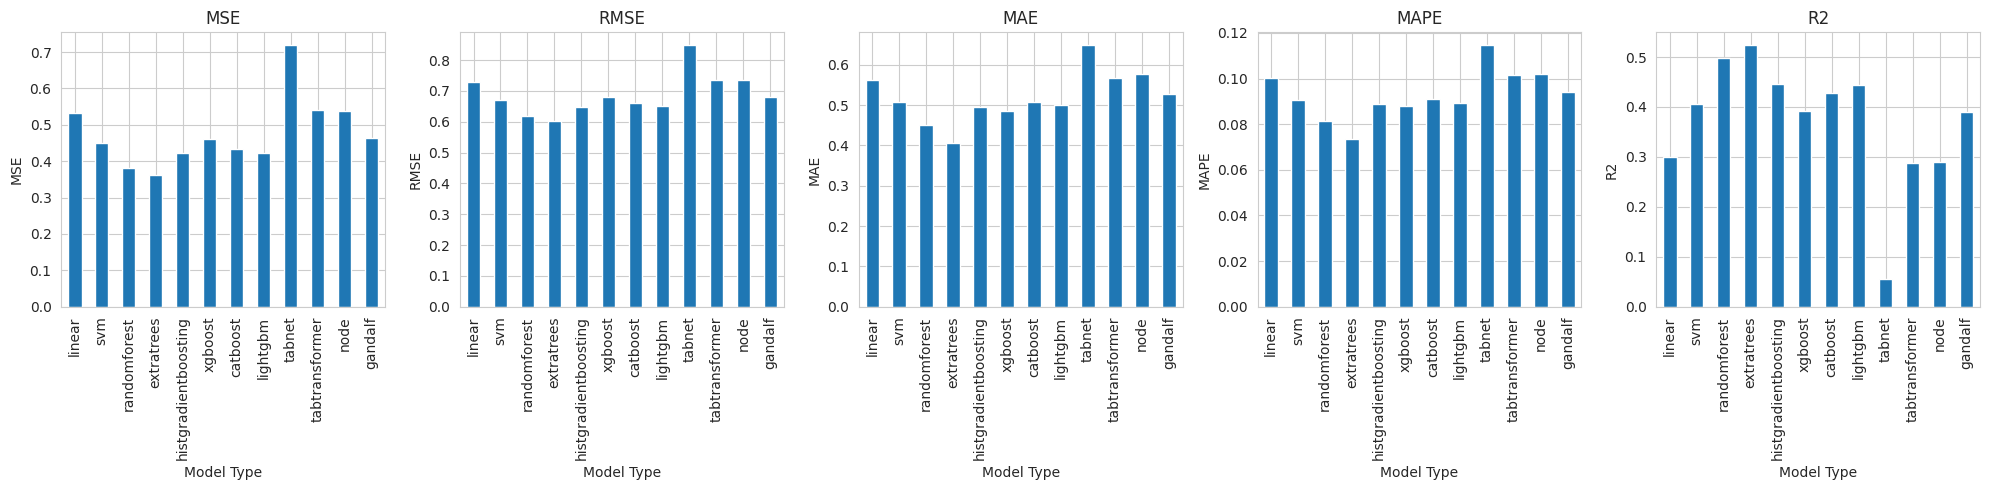

In [32]:
# Create plot of models' performances for each metric
fig, axes = plt.subplots(nrows=1, ncols=len(metrics_df.columns), figsize=(20, 5))
for i, metric in enumerate(metrics_df.columns):
    metrics_df[metric].plot(kind='bar', ax=axes[i], title=metric)
    axes[i].set_ylabel(metric)
    axes[i].set_xlabel("Model Type")

plt.tight_layout()
plt.show()